In [28]:
import random
import pandas as pd
import math
import copy
import matplotlib
import matplotlib.pyplot as plt

Подготовительные работы

Функции для работы с матрицами

In [101]:
def vector_mult(G, v):
    assert len(G[0]) == len(v)
    result = []
    for i in range(len(G)):
        total = 0
        for j in range(len(G[0])):
            total += G[i][j] * v[j]
        result.append(total)
    return result

def matrix_mult(A, B):
    assert len(A[0]) == len(B)
    zip_B = zip(*B)
    zip_B = list(zip_B)
    return [[sum(ele_A*ele_B for ele_A, ele_B in zip(row_A, col_B)) for col_B in zip_B] for row_A in A]

def string_mult(G, v):
    assert len(G) == len(v)
    result = []
    for i in range(len(G)):
        result_string = []
        for j in range(len(G[0])):
            result_string.append(G[i][j] * v[i])
        result.append(result_string)
    return result

Используемые метрики

In [102]:
def mse(y1, y2):
    assert len(y1) == len(y2)
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i]) ** 2
    mse /= len(y1)
    return mse

def r2(y1, y2):
    assert len(y1) == len(y2)
    RSS = 0
    for i in range(len(y1)):
        RSS += (y1[i] - y2[i]) ** 2
    y1_mean = sum(y1) / len(y1)
    TSS = 0
    for i in range(len(y1)):
        TSS += (y1[i] - y1_mean) ** 2
    R2 = 1 - RSS / TSS
    return R2

def r2_inverse(y1, y2):
    assert len(y1) == len(y2)
    RSS = 0
    for i in range(len(y1)):
        RSS += (y1[i] - y2[i]) ** 2
    y1_mean = sum(y1) / len(y1)
    TSS = 0
    for i in range(len(y1)):
        TSS += (y1[i] - y1_mean) ** 2

    R2 = RSS / TSS
    return R2

Линейная регрессия

In [103]:
class LinearRegression():
    def __init__(self, optimizer = 'sgd', r1=0, r2=0):
      self.w = None
      self.optimizer = optimizer
      self.r1 = r1
      self.r2 = r2 
      self.f = True
      self.save_weights = []
        
    def sgd_step(self, X, y, y_pred, lr):
      ind = random.randint(0, len(X)-1)
      grad = [(y_pred[ind] - y[ind]) * i for i in X[ind]]

      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def adagrad_step(self, X, y, y_pred, lr):
      grad = list(string_mult(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] += grad[i]**2
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]

    def rmsprop_step(self, X, y, y_pred, lr, b=0.5):
      grad = list(string_mult(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
      grad = [float(g/c) for g, c in zip(grad, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def adam_step(self, X, y, y_pred, lr, b=0.3, alpha=0.3):
      grad = list(string_mult(X,[i-j for i, j in zip(y_pred, y)]))
      grad = list(map(sum, zip(*grad)))
      grad = [gr/len(X) for gr in grad]
      for i in range(len(grad)):
        self.cache[i] = b*self.cache[i] + (1-b)*(grad[i]**2)
        self.velocity[i] = alpha*self.velocity[i] + (1-alpha)*grad[i]
      grad = [float(v/c) for v, c in zip(self.velocity, self.cache)]
      w_ = copy.deepcopy(self.w)
      w_[-1] = 0
      grad = [gr+self.r2*w for gr, w in zip(grad, self.w)]
      signw = list(map(lambda x: -1 if x < 0 else 1, w_))
      grad = [gr+self.r1*w for gr, w in zip(grad, signw)]
      self.w = [w-lr*gr for w, gr in zip(self.w, grad)]


    def get_weights(self):
      return self.w
    
    def get_losses(self):
        return self.losses

    def renewal(self):
        self.w = None
        self.losses = []
        self.f = True
        self.cache = []
        self.velocity = []
        
    def predict(self, X):
      if len(X[0]) == len(self.w):
        return  vector_mult(X, self.w)
      else:
        X_train = copy.deepcopy(X)
        for i in range(len(X_train)):
          X_train[i].append(1)
        return vector_mult(X_train, self.w)

    def fit(self, X, y, loss_func = mse, lr=0.1, max_iter=200, batch_size=128):
      n, m = len(X), len(X[0])
      X_train = copy.deepcopy(X)
      for i in range(len(X_train)):
        X_train[i].append(1)
          
      if self.w is None:
        self.w = []
        for i in range(m+1):
          self.w.append(1) 
      
      self.losses = []
      for iter_num in range(max_iter):
        y_pred = self.predict(X_train)
        self.losses.append(loss_func(y, y_pred))
        self.save_weights.append(self.get_weights())
        if self.optimizer == 'sgd':
          self.sgd_step(X_train, y, y_pred, lr)
        if self.optimizer == 'adagrad':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.adagrad_step(X_train, y, y_pred, lr)

        if self.optimizer == 'rmsprop':
          if self.f:
            self.cache = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)

        if self.optimizer == 'adam':
          if self.f:
            self.cache = []
            self.velocity = []
            self.f = False
            for i in range(len(self.w)):
              self.cache.append(0)
              self.velocity.append(0)
          self.rmsprop_step(X_train, y, y_pred, lr)


        print(f'iter_num: {iter_num}\tmse: {mse(y, y_pred)},r2: {r2(y, y_pred)} ,r2_inverse: {r2_inverse(y, y_pred)}')

Обработка датафрейма

In [104]:
data = pd.read_csv("data1.csv")
data = data.iloc[:, :-1]
data.sample(10)

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
435405,2002,2003.0,1.0,153.0,1062.0
301973,1525,1530.0,5.0,218.0,1426.0
300980,1525,NaN,NaN,94.0,301.0
211503,1220,1216.0,-4.0,119.0,588.0
469119,2150,2145.0,-5.0,59.0,135.0
123507,920,943.0,23.0,78.0,236.0
410471,1910,1902.0,-8.0,162.0,911.0
344435,1657,1704.0,7.0,244.0,1416.0
31729,625,625.0,0.0,95.0,438.0
200094,1200,1155.0,-5.0,58.0,116.0


In [105]:
data = data.dropna()
data = data.drop_duplicates()
time = data['CRS_DEP_TIME'].copy()
data['CRS_DEP_TIME'] = time % 100 + 60 * (time // 100)

In [106]:
y = data['DEP_DELAY']
y = y.tolist()

In [107]:
data.head()

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,5,2357.0,-8.0,209.0,1448.0
1,5,2.0,-3.0,287.0,2330.0
2,5,11.0,6.0,287.0,2330.0
3,5,148.0,103.0,287.0,2330.0
4,5,2359.0,-6.0,287.0,2330.0


In [108]:
X = data.drop(columns=['DEP_DELAY'])
X = X.values.tolist()

Нормировка данных

In [109]:
def fit_transform(X, mean=None, sigma=None):
    n, m = len(X), len(X[0])
    if mean is None or sigma is None:
        mean = []
        sigma = []
        f = False
    else:
        f = True
        
    for i in range(m):
        mean_x = 0
        for j in range(n):
            mean_x += X[j][i]
        if f:
            mean[i] = mean[i] * 0.5 + 0.5 * mean_x/n
        else:
            mean.append(mean_x / n)
        
    for i in range(m):
        sigma_x = 0
        for j in range(n):
                sigma_x += (X[j][i] - mean[i]) ** 2
        if f:
            sigma[i] = sigma[i] * 0.5 + 0.5 * (sigma_x/n) ** 0.5
        else:
            sigma.append((sigma_x / n) ** 0.5)
        
    for i in range(m):
        for j in range(n):
            X[j][i] = (X[j][i] - mean[i]) / sigma[i]
    
    return X

In [110]:
X = fit_transform(X)
X

[[-2.8565050634653395,
  1.9854234355930842,
  0.8944244784257572,
  1.036370551763419],
 [-2.8565050634653395,
  -2.7823227396774626,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.76410205365732,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.486742722017378,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  1.9894724769308938,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.7762491776707483,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.780298219008558,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.772200136332939,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  1.987447956261989,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  -2.7843472603463675,
  1.9409351011394567,
  2.508757201467931],
 [-2.8565050634653395,
  1.9854234355930842,
  1.9409351011394567,
  2.508757201467931],
 [-2.856505063465339

Батчи

In [111]:
def get_batch(X, y, n=128):
    assert len(X) >= n and len(y) >= n
    assert len(X) == len(y)
    dataset = []
    for x_val, y_val in zip(X,y):
        dataset.append(x_val + [y_val,])
    random.shuffle(dataset)
    while len(dataset) != 0:
        batch = []
        batch_size = min((n, len(dataset)))
        for i in range(batch_size):
            batch.append(dataset[i])
        
        x_batch = []
        y_batch = []
        for i in batch:
            x_batch.append(i[:-1])
            y_batch.append(i[-1])
        yield (x_batch, y_batch)
        dataset = dataset[n:]

In [112]:
max_iter = 1000
gen = get_batch(X, y, 1000)
X, y = next(gen)
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [113]:
linreg = LinearRegression(optimizer='sgd')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.001)

iter_num: 0	mse: 2305.5645344491127,r2: -0.051414792123465114 ,r2_inverse: 1.0514147921234651
iter_num: 1	mse: 2305.5896366425272,r2: -0.051426239565979026 ,r2_inverse: 1.051426239565979
iter_num: 2	mse: 2305.6526338486565,r2: -0.05145496840587804 ,r2_inverse: 1.051454968405878
iter_num: 3	mse: 2305.322346725409,r2: -0.051304346394721145 ,r2_inverse: 1.0513043463947211
iter_num: 4	mse: 2305.570842044837,r2: -0.05141766859876973 ,r2_inverse: 1.0514176685987697
iter_num: 5	mse: 2305.5362558430224,r2: -0.05140189613018453 ,r2_inverse: 1.0514018961301845
iter_num: 6	mse: 2305.785992819344,r2: -0.051515784571440904 ,r2_inverse: 1.051515784571441
iter_num: 7	mse: 2305.7291372640198,r2: -0.05148985653039562 ,r2_inverse: 1.0514898565303956
iter_num: 8	mse: 2305.8634572165256,r2: -0.05155111093591391 ,r2_inverse: 1.051551110935914
iter_num: 9	mse: 2306.015980131168,r2: -0.051620666502976364 ,r2_inverse: 1.0516206665029764
iter_num: 10	mse: 2305.998883051678,r2: -0.05161286966102763 ,r2_inverse:

iter_num: 97	mse: 2290.8843202977646,r2: -0.04472012186824448 ,r2_inverse: 1.0447201218682445
iter_num: 98	mse: 2291.1427051416485,r2: -0.04483795402729318 ,r2_inverse: 1.0448379540272932
iter_num: 99	mse: 2290.9239468374317,r2: -0.0447381929000219 ,r2_inverse: 1.044738192900022
iter_num: 100	mse: 2290.672651073038,r2: -0.04462359359909862 ,r2_inverse: 1.0446235935990986
iter_num: 101	mse: 2288.8682602975673,r2: -0.043800730858214676 ,r2_inverse: 1.0438007308582147
iter_num: 102	mse: 2288.862028934078,r2: -0.04379788914736693 ,r2_inverse: 1.043797889147367
iter_num: 103	mse: 2287.6094280693087,r2: -0.04322666112136009 ,r2_inverse: 1.04322666112136
iter_num: 104	mse: 2287.0742423156703,r2: -0.04298259845926533 ,r2_inverse: 1.0429825984592653
iter_num: 105	mse: 2287.0675700953716,r2: -0.042979555702919114 ,r2_inverse: 1.0429795557029191
iter_num: 106	mse: 2286.879120155659,r2: -0.04289361620687471 ,r2_inverse: 1.0428936162068747
iter_num: 107	mse: 2286.9815551133033,r2: -0.04294032998481

iter_num: 203	mse: 2265.6543754110853,r2: -0.03321442039602229 ,r2_inverse: 1.0332144203960223
iter_num: 204	mse: 2265.9212094300983,r2: -0.03333610566244638 ,r2_inverse: 1.0333361056624464
iter_num: 205	mse: 2265.6318992029132,r2: -0.03320417049089519 ,r2_inverse: 1.0332041704908952
iter_num: 206	mse: 2265.688991459386,r2: -0.03323020647560715 ,r2_inverse: 1.0332302064756071
iter_num: 207	mse: 2265.327022027599,r2: -0.03306513626864005 ,r2_inverse: 1.03306513626864
iter_num: 208	mse: 2265.0715306705647,r2: -0.03294862363668716 ,r2_inverse: 1.0329486236366872
iter_num: 209	mse: 2265.1863214684026,r2: -0.03300097209236608 ,r2_inverse: 1.033000972092366
iter_num: 210	mse: 2265.414909598082,r2: -0.03310521594989324 ,r2_inverse: 1.0331052159498932
iter_num: 211	mse: 2265.4748514453595,r2: -0.033132551443631586 ,r2_inverse: 1.0331325514436316
iter_num: 212	mse: 2265.589209683194,r2: -0.033184702637434116 ,r2_inverse: 1.0331847026374341
iter_num: 213	mse: 2265.6652157296926,r2: -0.0332193639

iter_num: 329	mse: 2253.13898274676,r2: -0.027506981380593043 ,r2_inverse: 1.027506981380593
iter_num: 330	mse: 2246.855890834585,r2: -0.024641680636230623 ,r2_inverse: 1.0246416806362306
iter_num: 331	mse: 2247.111911466178,r2: -0.02475843463514238 ,r2_inverse: 1.0247584346351424
iter_num: 332	mse: 2247.2337241262076,r2: -0.02481398529560286 ,r2_inverse: 1.0248139852956029
iter_num: 333	mse: 2247.5069811763697,r2: -0.024938599679759088 ,r2_inverse: 1.024938599679759
iter_num: 334	mse: 2247.8177158002495,r2: -0.025080305095109834 ,r2_inverse: 1.0250803050951098
iter_num: 335	mse: 2247.8408222930943,r2: -0.025090842431197524 ,r2_inverse: 1.0250908424311975
iter_num: 336	mse: 2248.028934273969,r2: -0.02517662780667118 ,r2_inverse: 1.0251766278066712
iter_num: 337	mse: 2247.8375918194583,r2: -0.025089369226819036 ,r2_inverse: 1.025089369226819
iter_num: 338	mse: 2248.0139577573436,r2: -0.025169798012545375 ,r2_inverse: 1.0251697980125454
iter_num: 339	mse: 2247.2090659368996,r2: -0.024802

iter_num: 418	mse: 2243.243770091026,r2: -0.02299443237058152 ,r2_inverse: 1.0229944323705815
iter_num: 419	mse: 2243.250176572814,r2: -0.022997353941249576 ,r2_inverse: 1.0229973539412496
iter_num: 420	mse: 2243.2168082365465,r2: -0.02298213686021988 ,r2_inverse: 1.0229821368602199
iter_num: 421	mse: 2243.383653564931,r2: -0.02305822392854484 ,r2_inverse: 1.0230582239285448
iter_num: 422	mse: 2243.615226873869,r2: -0.023163829127982982 ,r2_inverse: 1.023163829127983
iter_num: 423	mse: 2243.775284973756,r2: -0.023236820992364127 ,r2_inverse: 1.0232368209923641
iter_num: 424	mse: 2243.87968367002,r2: -0.023284430301012904 ,r2_inverse: 1.023284430301013
iter_num: 425	mse: 2244.000101145125,r2: -0.02333934471033161 ,r2_inverse: 1.0233393447103316
iter_num: 426	mse: 2243.974436133146,r2: -0.023327640603666433 ,r2_inverse: 1.0233276406036664
iter_num: 427	mse: 2244.017728924654,r2: -0.0233473835693061 ,r2_inverse: 1.023347383569306
iter_num: 428	mse: 2244.018829870601,r2: -0.023347885637601

iter_num: 537	mse: 2226.7591259587634,r2: -0.015476881495479544 ,r2_inverse: 1.0154768814954795
iter_num: 538	mse: 2227.049791482919,r2: -0.015609434727926974 ,r2_inverse: 1.015609434727927
iter_num: 539	mse: 2224.052210063731,r2: -0.014242437015376641 ,r2_inverse: 1.0142424370153766
iter_num: 540	mse: 2223.9877608713323,r2: -0.014213046021016806 ,r2_inverse: 1.0142130460210168
iter_num: 541	mse: 2223.8081689902774,r2: -0.014131146096957092 ,r2_inverse: 1.014131146096957
iter_num: 542	mse: 2223.9106860455763,r2: -0.014177897314186394 ,r2_inverse: 1.0141778973141864
iter_num: 543	mse: 2224.3611557497175,r2: -0.01438332661501951 ,r2_inverse: 1.0143833266150195
iter_num: 544	mse: 2224.2567052977156,r2: -0.014335693704017327 ,r2_inverse: 1.0143356937040173
iter_num: 545	mse: 2223.823643444869,r2: -0.014138202967504121 ,r2_inverse: 1.0141382029675041
iter_num: 546	mse: 2223.8434960185305,r2: -0.014147256407257336 ,r2_inverse: 1.0141472564072573
iter_num: 547	mse: 2224.0455957636746,r2: -0.0

iter_num: 713	mse: 2209.136422114939,r2: -0.007440337203720837 ,r2_inverse: 1.0074403372037208
iter_num: 714	mse: 2209.2645029347536,r2: -0.007498746355374841 ,r2_inverse: 1.0074987463553748
iter_num: 715	mse: 2209.4972971723428,r2: -0.007604908339246874 ,r2_inverse: 1.0076049083392469
iter_num: 716	mse: 2209.5826653491504,r2: -0.007643839092444482 ,r2_inverse: 1.0076438390924445
iter_num: 717	mse: 2209.6239902521525,r2: -0.0076626846348921696 ,r2_inverse: 1.0076626846348922
iter_num: 718	mse: 2209.6114615452757,r2: -0.007656971124148981 ,r2_inverse: 1.007656971124149
iter_num: 719	mse: 2209.667313725708,r2: -0.00768244159257514 ,r2_inverse: 1.0076824415925751
iter_num: 720	mse: 2209.8940584274296,r2: -0.007785844785096252 ,r2_inverse: 1.0077858447850963
iter_num: 721	mse: 2209.909588749528,r2: -0.007792927133101202 ,r2_inverse: 1.0077929271331012
iter_num: 722	mse: 2210.052171344489,r2: -0.00785794958083641 ,r2_inverse: 1.0078579495808364
iter_num: 723	mse: 2209.9996742418375,r2: -0.0

iter_num: 829	mse: 2203.241655616913,r2: -0.004752125878671354 ,r2_inverse: 1.0047521258786714
iter_num: 830	mse: 2203.279046161826,r2: -0.004769177221811027 ,r2_inverse: 1.004769177221811
iter_num: 831	mse: 2203.365981349317,r2: -0.004808822584462025 ,r2_inverse: 1.004808822584462
iter_num: 832	mse: 2203.0999793520587,r2: -0.004687516747877263 ,r2_inverse: 1.0046875167478773
iter_num: 833	mse: 2203.004721925555,r2: -0.004644076164979083 ,r2_inverse: 1.004644076164979
iter_num: 834	mse: 2203.059411627447,r2: -0.0046690165041833875 ,r2_inverse: 1.0046690165041834
iter_num: 835	mse: 2202.2383753629856,r2: -0.004294596417290908 ,r2_inverse: 1.004294596417291
iter_num: 836	mse: 2202.3241952887447,r2: -0.004333733183168986 ,r2_inverse: 1.004333733183169
iter_num: 837	mse: 2202.4086848956363,r2: -0.004372263279004418 ,r2_inverse: 1.0043722632790044
iter_num: 838	mse: 2202.597012658894,r2: -0.004458147058485684 ,r2_inverse: 1.0044581470584857
iter_num: 839	mse: 2202.750686806078,r2: -0.004528

iter_num: 934	mse: 2191.1739803406863,r2: 0.0007511389843957161 ,r2_inverse: 0.9992488610156043
iter_num: 935	mse: 2191.196825851487,r2: 0.0007407206648775144 ,r2_inverse: 0.9992592793351225
iter_num: 936	mse: 2191.2032137673154,r2: 0.0007378075609100199 ,r2_inverse: 0.99926219243909
iter_num: 937	mse: 2191.2490674446053,r2: 0.0007168967454217468 ,r2_inverse: 0.9992831032545783
iter_num: 938	mse: 2191.235340976019,r2: 0.0007231564756959852 ,r2_inverse: 0.999276843524304
iter_num: 939	mse: 2191.2132303408453,r2: 0.0007332396672690145 ,r2_inverse: 0.999266760332731
iter_num: 940	mse: 2191.152295108349,r2: 0.0007610281780006112 ,r2_inverse: 0.9992389718219994
iter_num: 941	mse: 2191.229786296999,r2: 0.000725689595719281 ,r2_inverse: 0.9992743104042807
iter_num: 942	mse: 2191.3464446605253,r2: 0.0006724894674192683 ,r2_inverse: 0.9993275105325807
iter_num: 943	mse: 2191.4516213357456,r2: 0.0006245253742609425 ,r2_inverse: 0.9993754746257391
iter_num: 944	mse: 2191.4019541625103,r2: 0.00064

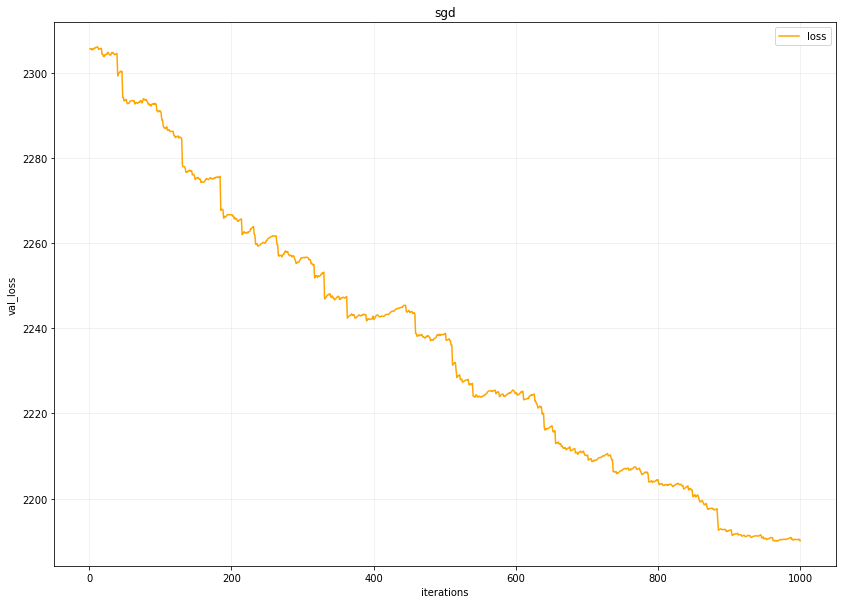

mse on test: 2082.245760643319, r2 on test: 0.030975047181654336


In [114]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc, val_loss, label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('sgd')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [115]:
linreg = LinearRegression(optimizer='adagrad')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 2305.5645344491127,r2: -0.051414792123465114 ,r2_inverse: 1.0514147921234651
iter_num: 1	mse: 2313.185573438879,r2: -0.05489024163071732 ,r2_inverse: 1.0548902416307173
iter_num: 2	mse: 2313.1157943193534,r2: -0.05485842001073937 ,r2_inverse: 1.0548584200107394
iter_num: 3	mse: 2313.075748368478,r2: -0.05484015771337725 ,r2_inverse: 1.0548401577133772
iter_num: 4	mse: 2313.047391895902,r2: -0.0548272262103664 ,r2_inverse: 1.0548272262103664
iter_num: 5	mse: 2313.025389694791,r2: -0.054817192468364695 ,r2_inverse: 1.0548171924683647
iter_num: 6	mse: 2313.007399632635,r2: -0.05480898839635562 ,r2_inverse: 1.0548089883963556
iter_num: 7	mse: 2312.9921781939697,r2: -0.05480204690956114 ,r2_inverse: 1.0548020469095611
iter_num: 8	mse: 2312.978984213119,r2: -0.05479603001156219 ,r2_inverse: 1.0547960300115622
iter_num: 9	mse: 2312.9673397436145,r2: -0.054790719742731975 ,r2_inverse: 1.054790719742732
iter_num: 10	mse: 2312.95691836227,r2: -0.054785967243143885 ,r2_inverse: 1

iter_num: 128	mse: 2312.7038889932765,r2: -0.05467057736035108 ,r2_inverse: 1.054670577360351
iter_num: 129	mse: 2312.703115404108,r2: -0.05467022457773196 ,r2_inverse: 1.054670224577732
iter_num: 130	mse: 2312.70234778597,r2: -0.05466987451810312 ,r2_inverse: 1.0546698745181031
iter_num: 131	mse: 2312.7015860474003,r2: -0.054669527139755036 ,r2_inverse: 1.054669527139755
iter_num: 132	mse: 2312.700830099011,r2: -0.0546691824019232 ,r2_inverse: 1.0546691824019232
iter_num: 133	mse: 2312.7000798534423,r2: -0.054668840264769036 ,r2_inverse: 1.054668840264769
iter_num: 134	mse: 2312.6993352252916,r2: -0.05466850068934592 ,r2_inverse: 1.054668500689346
iter_num: 135	mse: 2312.698596131073,r2: -0.054668163637581424 ,r2_inverse: 1.0546681636375814
iter_num: 136	mse: 2312.697862489132,r2: -0.05466782907223888 ,r2_inverse: 1.0546678290722389
iter_num: 137	mse: 2312.6971342196152,r2: -0.05466749695690165 ,r2_inverse: 1.0546674969569017
iter_num: 138	mse: 2312.696411244418,r2: -0.054667167255951

iter_num: 243	mse: 2312.6401594626227,r2: -0.05464151455589561 ,r2_inverse: 1.0546415145558956
iter_num: 244	mse: 2312.639751139678,r2: -0.05464132834693136 ,r2_inverse: 1.0546413283469314
iter_num: 245	mse: 2312.639344486402,r2: -0.05464114289939204 ,r2_inverse: 1.054641142899392
iter_num: 246	mse: 2312.6389394891985,r2: -0.05464095820707726 ,r2_inverse: 1.0546409582070773
iter_num: 247	mse: 2312.638536134624,r2: -0.054640774263856384 ,r2_inverse: 1.0546407742638564
iter_num: 248	mse: 2312.638134409407,r2: -0.05464059106367736 ,r2_inverse: 1.0546405910636774
iter_num: 249	mse: 2312.637734300442,r2: -0.05464040860056363 ,r2_inverse: 1.0546404086005636
iter_num: 250	mse: 2312.6373357947787,r2: -0.05464022686860881 ,r2_inverse: 1.0546402268686088
iter_num: 251	mse: 2312.636938879611,r2: -0.05464004586197402 ,r2_inverse: 1.054640045861974
iter_num: 252	mse: 2312.6365435422986,r2: -0.05463986557489364 ,r2_inverse: 1.0546398655748936
iter_num: 253	mse: 2312.636149770354,r2: -0.0546396860016

iter_num: 382	mse: 2312.5951810718266,r2: -0.05462100290041905 ,r2_inverse: 1.054621002900419
iter_num: 383	mse: 2312.594921112819,r2: -0.05462088435038881 ,r2_inverse: 1.0546208843503888
iter_num: 384	mse: 2312.5946618315807,r2: -0.05462076610944355 ,r2_inverse: 1.0546207661094436
iter_num: 385	mse: 2312.5944032245934,r2: -0.05462064817597989 ,r2_inverse: 1.05462064817598
iter_num: 386	mse: 2312.594145288355,r2: -0.05462053054839977 ,r2_inverse: 1.0546205305483998
iter_num: 387	mse: 2312.5938880193994,r2: -0.054620413225123565 ,r2_inverse: 1.0546204132251236
iter_num: 388	mse: 2312.593631414279,r2: -0.05462029620457787 ,r2_inverse: 1.0546202962045779
iter_num: 389	mse: 2312.5933754695743,r2: -0.05462017948520437 ,r2_inverse: 1.0546201794852044
iter_num: 390	mse: 2312.5931201819035,r2: -0.05462006306546008 ,r2_inverse: 1.05462006306546
iter_num: 391	mse: 2312.5928655478924,r2: -0.054619946943806674 ,r2_inverse: 1.0546199469438067
iter_num: 392	mse: 2312.592611564213,r2: -0.054619831118

iter_num: 535	mse: 2312.5616863991063,r2: -0.05460572820572751 ,r2_inverse: 1.0546057282057275
iter_num: 536	mse: 2312.561500707683,r2: -0.05460564352420749 ,r2_inverse: 1.0546056435242075
iter_num: 537	mse: 2312.5613153623417,r2: -0.05460555900051256 ,r2_inverse: 1.0546055590005126
iter_num: 538	mse: 2312.5611303618075,r2: -0.0546054746340614 ,r2_inverse: 1.0546054746340614
iter_num: 539	mse: 2312.5609457047867,r2: -0.05460539042426338 ,r2_inverse: 1.0546053904242634
iter_num: 540	mse: 2312.560761390021,r2: -0.054605306370545614 ,r2_inverse: 1.0546053063705456
iter_num: 541	mse: 2312.5605774162336,r2: -0.05460522247232502 ,r2_inverse: 1.054605222472325
iter_num: 542	mse: 2312.5603937821675,r2: -0.05460513872902917 ,r2_inverse: 1.0546051387290292
iter_num: 543	mse: 2312.5602104865716,r2: -0.05460505514008673 ,r2_inverse: 1.0546050551400867
iter_num: 544	mse: 2312.560027528198,r2: -0.054604971704929284 ,r2_inverse: 1.0546049717049293
iter_num: 545	mse: 2312.559844905807,r2: -0.054604888

iter_num: 687	mse: 2312.536820029524,r2: -0.054594388306794084 ,r2_inverse: 1.054594388306794
iter_num: 688	mse: 2312.5366753903754,r2: -0.05459432234648909 ,r2_inverse: 1.054594322346489
iter_num: 689	mse: 2312.536530961302,r2: -0.05459425648198524 ,r2_inverse: 1.0545942564819852
iter_num: 690	mse: 2312.536386741682,r2: -0.05459419071299898 ,r2_inverse: 1.054594190712999
iter_num: 691	mse: 2312.536242730912,r2: -0.05459412503925565 ,r2_inverse: 1.0545941250392556
iter_num: 692	mse: 2312.5360989283927,r2: -0.05459405946048146 ,r2_inverse: 1.0545940594604815
iter_num: 693	mse: 2312.5359553335193,r2: -0.054593993976400634 ,r2_inverse: 1.0545939939764006
iter_num: 694	mse: 2312.5358119456914,r2: -0.05459392858673984 ,r2_inverse: 1.0545939285867398
iter_num: 695	mse: 2312.5356687643143,r2: -0.054593863291227285 ,r2_inverse: 1.0545938632912273
iter_num: 696	mse: 2312.5355257887954,r2: -0.05459379808959297 ,r2_inverse: 1.054593798089593
iter_num: 697	mse: 2312.535383018545,r2: -0.05459373298

iter_num: 814	mse: 2312.5199524458276,r2: -0.05458669612262823 ,r2_inverse: 1.0545866961226282
iter_num: 815	mse: 2312.5198303584207,r2: -0.05458664044667394 ,r2_inverse: 1.054586640446674
iter_num: 816	mse: 2312.519708420718,r2: -0.054586584838989705 ,r2_inverse: 1.0545865848389897
iter_num: 817	mse: 2312.5195866323497,r2: -0.054586529299407216 ,r2_inverse: 1.0545865292994072
iter_num: 818	mse: 2312.51946499295,r2: -0.05458647382775905 ,r2_inverse: 1.054586473827759
iter_num: 819	mse: 2312.5193435021606,r2: -0.054586418423882455 ,r2_inverse: 1.0545864184238825
iter_num: 820	mse: 2312.5192221596167,r2: -0.05458636308761089 ,r2_inverse: 1.054586363087611
iter_num: 821	mse: 2312.5191009649493,r2: -0.0545863078187756 ,r2_inverse: 1.0545863078187756
iter_num: 822	mse: 2312.5189799178124,r2: -0.05458625261721939 ,r2_inverse: 1.0545862526172194
iter_num: 823	mse: 2312.5188590178377,r2: -0.05458619748277416 ,r2_inverse: 1.0545861974827742
iter_num: 824	mse: 2312.5187382646673,r2: -0.054586142

iter_num: 947	mse: 2312.5049032552884,r2: -0.05457983318675885 ,r2_inverse: 1.0545798331867589
iter_num: 948	mse: 2312.5047983046807,r2: -0.05457978532576013 ,r2_inverse: 1.0545797853257601
iter_num: 949	mse: 2312.5046934647257,r2: -0.054579737515222604 ,r2_inverse: 1.0545797375152226
iter_num: 950	mse: 2312.504588735179,r2: -0.05457968975503502 ,r2_inverse: 1.054579689755035
iter_num: 951	mse: 2312.504484115817,r2: -0.05457964204509547 ,r2_inverse: 1.0545796420450955
iter_num: 952	mse: 2312.504379606404,r2: -0.05457959438529625 ,r2_inverse: 1.0545795943852962
iter_num: 953	mse: 2312.5042752067043,r2: -0.0545795467755299 ,r2_inverse: 1.05457954677553
iter_num: 954	mse: 2312.5041709164957,r2: -0.05457949921569538 ,r2_inverse: 1.0545794992156954
iter_num: 955	mse: 2312.504066735546,r2: -0.054579451705686344 ,r2_inverse: 1.0545794517056863
iter_num: 956	mse: 2312.5039626636235,r2: -0.054579404245397756 ,r2_inverse: 1.0545794042453978
iter_num: 957	mse: 2312.5038587005083,r2: -0.0545793568

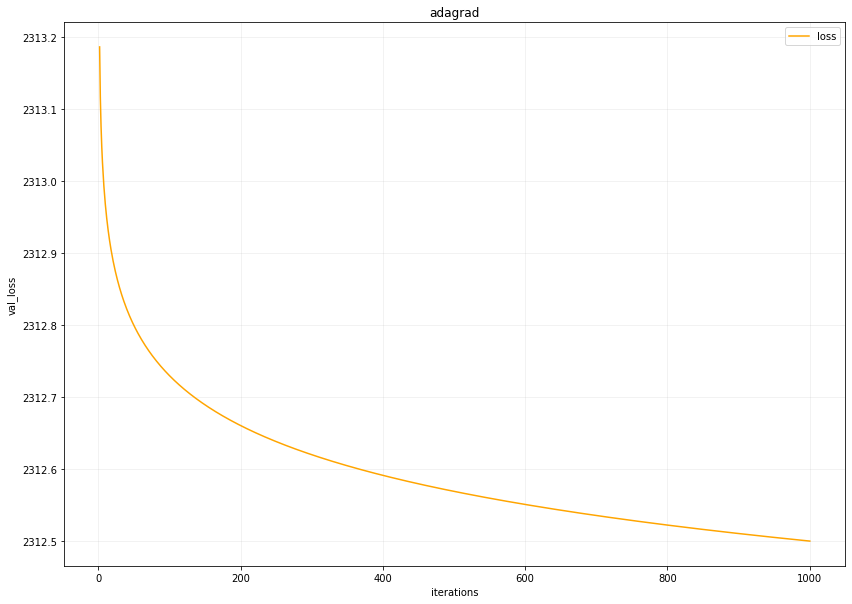

mse on test: 2274.670868026164, r2 on test: -0.05857477163757929


In [116]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.title('adagrad')
plt.grid(alpha=0.2)
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [117]:
linreg = LinearRegression(optimizer='rmsprop')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 2305.5645344491127,r2: -0.051414792123465114 ,r2_inverse: 1.0514147921234651
iter_num: 1	mse: 2336.2486904081657,r2: -0.06540779686357312 ,r2_inverse: 1.0654077968635731
iter_num: 2	mse: 2336.0853248669846,r2: -0.06533329669497889 ,r2_inverse: 1.065333296694979
iter_num: 3	mse: 2335.962455608632,r2: -0.06527726419022839 ,r2_inverse: 1.0652772641902284
iter_num: 4	mse: 2335.852530449366,r2: -0.06522713462900742 ,r2_inverse: 1.0652271346290074
iter_num: 5	mse: 2335.7480203123137,r2: -0.06517947449961947 ,r2_inverse: 1.0651794744996195
iter_num: 6	mse: 2335.6460064737907,r2: -0.06513295276612596 ,r2_inverse: 1.065132952766126
iter_num: 7	mse: 2335.545193745933,r2: -0.0650869787793995 ,r2_inverse: 1.0650869787793995
iter_num: 8	mse: 2335.4449710459694,r2: -0.06504127386519132 ,r2_inverse: 1.0650412738651913
iter_num: 9	mse: 2335.345041467503,r2: -0.06499570262422183 ,r2_inverse: 1.0649957026242218
iter_num: 10	mse: 2335.2452586659365,r2: -0.06495019831844373 ,r2_inverse: 1

iter_num: 91	mse: 2327.1835818557693,r2: -0.06127380317925746 ,r2_inverse: 1.0612738031792575
iter_num: 92	mse: 2327.0842391472365,r2: -0.06122849957067045 ,r2_inverse: 1.0612284995706704
iter_num: 93	mse: 2326.9849039190017,r2: -0.06118319937335026 ,r2_inverse: 1.0611831993733503
iter_num: 94	mse: 2326.8855763736456,r2: -0.061137902679680556 ,r2_inverse: 1.0611379026796806
iter_num: 95	mse: 2326.786256722394,r2: -0.06109260958598717 ,r2_inverse: 1.0610926095859872
iter_num: 96	mse: 2326.686945185642,r2: -0.061047320192778365 ,r2_inverse: 1.0610473201927784
iter_num: 97	mse: 2326.587641993484,r2: -0.06100203460498399 ,r2_inverse: 1.061002034604984
iter_num: 98	mse: 2326.488347386297,r2: -0.0609567529322248 ,r2_inverse: 1.0609567529322248
iter_num: 99	mse: 2326.3890616154013,r2: -0.06091147528911067 ,r2_inverse: 1.0609114752891107
iter_num: 100	mse: 2326.289784943677,r2: -0.060866201795524155 ,r2_inverse: 1.0608662017955242
iter_num: 101	mse: 2326.190517646372,r2: -0.06082093257698751 ,

iter_num: 201	mse: 2317.1143779091876,r2: -0.056681908302251616 ,r2_inverse: 1.0566819083022516
iter_num: 202	mse: 2317.036277456104,r2: -0.05664629187494419 ,r2_inverse: 1.0566462918749442
iter_num: 203	mse: 2316.954530321298,r2: -0.05660901243840488 ,r2_inverse: 1.0566090124384049
iter_num: 204	mse: 2316.8764321647654,r2: -0.05657339705840192 ,r2_inverse: 1.056573397058402
iter_num: 205	mse: 2316.7946852750256,r2: -0.056536117733621216 ,r2_inverse: 1.0565361177336212
iter_num: 206	mse: 2316.716587775342,r2: -0.05650050265316331 ,r2_inverse: 1.0565005026531633
iter_num: 207	mse: 2316.6348401168084,r2: -0.05646322297778705 ,r2_inverse: 1.056463222977787
iter_num: 208	mse: 2316.5567444209423,r2: -0.05642760871993047 ,r2_inverse: 1.0564276087199305
iter_num: 209	mse: 2316.474996280596,r2: -0.056390328824831304 ,r2_inverse: 1.0563903288248313
iter_num: 210	mse: 2316.396901790109,r2: -0.0563547151166679 ,r2_inverse: 1.056354715116668
iter_num: 211	mse: 2316.3151531703547,r2: -0.05631743500

iter_num: 321	mse: 2307.525439924401,r2: -0.05230903081939742 ,r2_inverse: 1.0523090308193974
iter_num: 322	mse: 2307.4474365259903,r2: -0.05227345865227773 ,r2_inverse: 1.0522734586522777
iter_num: 323	mse: 2307.3656638651637,r2: -0.0522361675750167 ,r2_inverse: 1.0522361675750167
iter_num: 324	mse: 2307.2876623931065,r2: -0.05220059628637874 ,r2_inverse: 1.0522005962863787
iter_num: 325	mse: 2307.205889428902,r2: -0.052163305070767274 ,r2_inverse: 1.0521633050707673
iter_num: 326	mse: 2307.127889897015,r2: -0.05212773466691201 ,r2_inverse: 1.052127734666912
iter_num: 327	mse: 2307.0461166358564,r2: -0.05209044331587931 ,r2_inverse: 1.0520904433158793
iter_num: 328	mse: 2306.9681190581714,r2: -0.05205487380320584 ,r2_inverse: 1.0520548738032058
iter_num: 329	mse: 2306.886345506602,r2: -0.05201758231973619 ,r2_inverse: 1.0520175823197362
iter_num: 330	mse: 2306.8083498974006,r2: -0.05198201370475708 ,r2_inverse: 1.051982013704757
iter_num: 331	mse: 2306.7265760621226,r2: -0.05194472209

iter_num: 456	mse: 2296.7475870721296,r2: -0.04739396826231501 ,r2_inverse: 1.047393968262315
iter_num: 457	mse: 2296.66581973354,r2: -0.047356679612172714 ,r2_inverse: 1.0473566796121727
iter_num: 458	mse: 2296.5879973087904,r2: -0.04732118997511492 ,r2_inverse: 1.047321189975115
iter_num: 459	mse: 2296.506230752462,r2: -0.04728390168171015 ,r2_inverse: 1.0472839016817101
iter_num: 460	mse: 2296.428412224443,r2: -0.0472484138216922 ,r2_inverse: 1.0472484138216922
iter_num: 461	mse: 2296.346646487103,r2: -0.04721112590177334 ,r2_inverse: 1.0472111259017733
iter_num: 462	mse: 2296.268831915688,r2: -0.04717563984610007 ,r2_inverse: 1.0471756398461
iter_num: 463	mse: 2296.1870670352628,r2: -0.04713835231696284 ,r2_inverse: 1.0471383523169628
iter_num: 464	mse: 2296.109256482093,r2: -0.04710286809374398 ,r2_inverse: 1.047102868093744
iter_num: 465	mse: 2296.0274924977775,r2: -0.04706558097326319 ,r2_inverse: 1.0470655809732632
iter_num: 466	mse: 2295.9496860263375,r2: -0.04703009861145002 

iter_num: 611	mse: 2284.4097679037573,r2: -0.04176750871961099 ,r2_inverse: 1.041767508719611
iter_num: 612	mse: 2284.3329495249777,r2: -0.04173247696120708 ,r2_inverse: 1.041732476961207
iter_num: 613	mse: 2284.2517758189156,r2: -0.04169545902741678 ,r2_inverse: 1.0416954590274168
iter_num: 614	mse: 2284.1750115533523,r2: -0.04166045194645518 ,r2_inverse: 1.0416604519464552
iter_num: 615	mse: 2284.0938795720126,r2: -0.041623453040538605 ,r2_inverse: 1.0416234530405386
iter_num: 616	mse: 2284.017174372684,r2: -0.04158847289576184 ,r2_inverse: 1.0415884728957618
iter_num: 617	mse: 2283.9360884991847,r2: -0.04155149501656763 ,r2_inverse: 1.0415514950165676
iter_num: 618	mse: 2283.859448058425,r2: -0.04151654440387165 ,r2_inverse: 1.0415165444038716
iter_num: 619	mse: 2283.778413374088,r2: -0.041479589868652855 ,r2_inverse: 1.0414795898686529
iter_num: 620	mse: 2283.7018442796675,r2: -0.041444671792281396 ,r2_inverse: 1.0414446717922814
iter_num: 621	mse: 2283.620866719528,r2: -0.04140774

iter_num: 749	mse: 2275.3811013346426,r2: -0.037650133802501484 ,r2_inverse: 1.0376501338025015
iter_num: 750	mse: 2275.3262332393933,r2: -0.03762511210994046 ,r2_inverse: 1.0376251121099405
iter_num: 751	mse: 2275.2662545076637,r2: -0.03759775979565427 ,r2_inverse: 1.0375977597956543
iter_num: 752	mse: 2275.2095976125383,r2: -0.03757192235032547 ,r2_inverse: 1.0375719223503255
iter_num: 753	mse: 2275.1405923841007,r2: -0.03754045365065184 ,r2_inverse: 1.0375404536506518
iter_num: 754	mse: 2275.085718254337,r2: -0.0375154292061497 ,r2_inverse: 1.0375154292061497
iter_num: 755	mse: 2275.02577437055,r2: -0.03748809278369469 ,r2_inverse: 1.0374880927836947
iter_num: 756	mse: 2274.96910514318,r2: -0.03746224971444856 ,r2_inverse: 1.0374622497144486
iter_num: 757	mse: 2274.90008834575,r2: -0.03743077573892606 ,r2_inverse: 1.037430775738926
iter_num: 758	mse: 2274.8452080692155,r2: -0.03740574849129019 ,r2_inverse: 1.0374057484912902
iter_num: 759	mse: 2274.7852992657945,r2: -0.0373784280666

iter_num: 891	mse: 2266.8530805662567,r2: -0.03376107016995422 ,r2_inverse: 1.0337610701699542
iter_num: 892	mse: 2266.7959662708618,r2: -0.03373502413475449 ,r2_inverse: 1.0337350241347545
iter_num: 893	mse: 2266.7265561158047,r2: -0.033703370774954555 ,r2_inverse: 1.0337033707749546
iter_num: 894	mse: 2266.67137673938,r2: -0.033678207127732174 ,r2_inverse: 1.0336782071277322
iter_num: 895	mse: 2266.612838283189,r2: -0.03365151162742075 ,r2_inverse: 1.0336515116274207
iter_num: 896	mse: 2266.5557105388884,r2: -0.033625459459068585 ,r2_inverse: 1.0336254594590686
iter_num: 897	mse: 2266.486288386608,r2: -0.03359380062813244 ,r2_inverse: 1.0335938006281324
iter_num: 898	mse: 2266.4310965593913,r2: -0.03356863130293131 ,r2_inverse: 1.0335686313029313
iter_num: 899	mse: 2266.3726051570893,r2: -0.03354195726077225 ,r2_inverse: 1.0335419572607722
iter_num: 900	mse: 2266.315463989719,r2: -0.03351589897104956 ,r2_inverse: 1.0335158989710496
iter_num: 901	mse: 2266.246029771135,r2: -0.03348423

iter_num: 981	mse: 2261.4430551798055,r2: -0.0312939170575226 ,r2_inverse: 1.0312939170575226
iter_num: 982	mse: 2261.387510063185,r2: -0.03126858662049825 ,r2_inverse: 1.0312685866204983
iter_num: 983	mse: 2261.3301515147937,r2: -0.03124242919773601 ,r2_inverse: 1.031242429197736
iter_num: 984	mse: 2261.2727559979307,r2: -0.031216254916110353 ,r2_inverse: 1.0312162549161104
iter_num: 985	mse: 2261.203032172286,r2: -0.031184458511996915 ,r2_inverse: 1.031184458511997
iter_num: 986	mse: 2261.147463885944,r2: -0.031159117508802403 ,r2_inverse: 1.0311591175088024
iter_num: 987	mse: 2261.090168368282,r2: -0.031132988830167463 ,r2_inverse: 1.0311329888301675
iter_num: 988	mse: 2261.032763914709,r2: -0.031106810473102042 ,r2_inverse: 1.031106810473102
iter_num: 989	mse: 2260.963022793361,r2: -0.031075006181567666 ,r2_inverse: 1.0310750061815677
iter_num: 990	mse: 2260.907430464638,r2: -0.031049654214240663 ,r2_inverse: 1.0310496542142407
iter_num: 991	mse: 2260.850199112437,r2: -0.0310235547

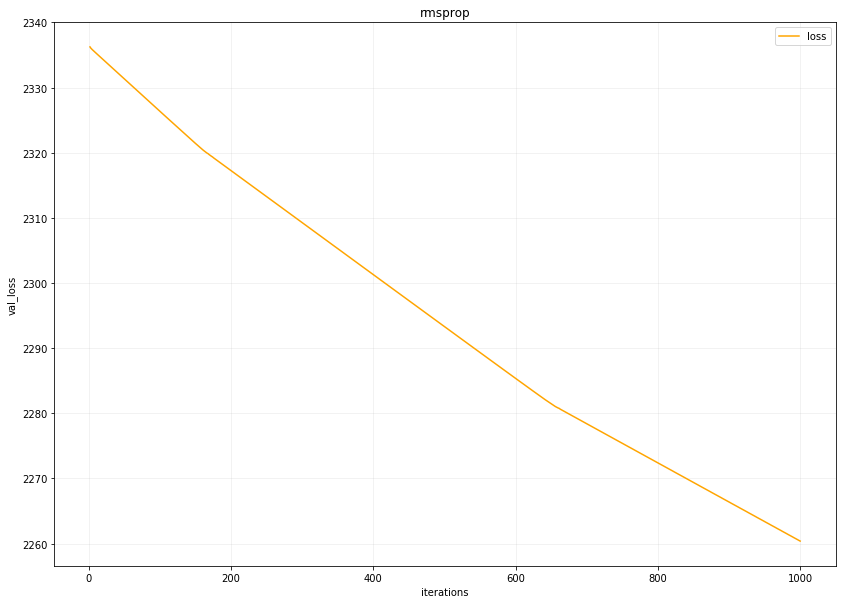

mse on test: 2160.8843543804837, r2 on test: -0.005621382032500621


In [118]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('rmsprop')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [119]:
linreg = LinearRegression(optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter, lr=0.01)

iter_num: 0	mse: 2305.5645344491127,r2: -0.051414792123465114 ,r2_inverse: 1.0514147921234651
iter_num: 1	mse: 2336.2486904081657,r2: -0.06540779686357312 ,r2_inverse: 1.0654077968635731
iter_num: 2	mse: 2336.0853248669846,r2: -0.06533329669497889 ,r2_inverse: 1.065333296694979
iter_num: 3	mse: 2335.962455608632,r2: -0.06527726419022839 ,r2_inverse: 1.0652772641902284
iter_num: 4	mse: 2335.852530449366,r2: -0.06522713462900742 ,r2_inverse: 1.0652271346290074
iter_num: 5	mse: 2335.7480203123137,r2: -0.06517947449961947 ,r2_inverse: 1.0651794744996195
iter_num: 6	mse: 2335.6460064737907,r2: -0.06513295276612596 ,r2_inverse: 1.065132952766126
iter_num: 7	mse: 2335.545193745933,r2: -0.0650869787793995 ,r2_inverse: 1.0650869787793995
iter_num: 8	mse: 2335.4449710459694,r2: -0.06504127386519132 ,r2_inverse: 1.0650412738651913
iter_num: 9	mse: 2335.345041467503,r2: -0.06499570262422183 ,r2_inverse: 1.0649957026242218
iter_num: 10	mse: 2335.2452586659365,r2: -0.06495019831844373 ,r2_inverse: 1

iter_num: 95	mse: 2326.786256722394,r2: -0.06109260958598717 ,r2_inverse: 1.0610926095859872
iter_num: 96	mse: 2326.686945185642,r2: -0.061047320192778365 ,r2_inverse: 1.0610473201927784
iter_num: 97	mse: 2326.587641993484,r2: -0.06100203460498399 ,r2_inverse: 1.061002034604984
iter_num: 98	mse: 2326.488347386297,r2: -0.0609567529322248 ,r2_inverse: 1.0609567529322248
iter_num: 99	mse: 2326.3890616154013,r2: -0.06091147528911067 ,r2_inverse: 1.0609114752891107
iter_num: 100	mse: 2326.289784943677,r2: -0.060866201795524155 ,r2_inverse: 1.0608662017955242
iter_num: 101	mse: 2326.190517646372,r2: -0.06082093257698751 ,r2_inverse: 1.0608209325769875
iter_num: 102	mse: 2326.091260011831,r2: -0.06077566776499532 ,r2_inverse: 1.0607756677649953
iter_num: 103	mse: 2325.992012342378,r2: -0.06073040749741776 ,r2_inverse: 1.0607304074974178
iter_num: 104	mse: 2325.89277495525,r2: -0.06068515191892532 ,r2_inverse: 1.0606851519189253
iter_num: 105	mse: 2325.7935481835893,r2: -0.060639901181442246 ,

iter_num: 191	mse: 2317.9136513768967,r2: -0.05704640382356274 ,r2_inverse: 1.0570464038235627
iter_num: 192	mse: 2317.835511042554,r2: -0.05701076920906334 ,r2_inverse: 1.0570107692090633
iter_num: 193	mse: 2317.7537586840135,r2: -0.05697348739032604 ,r2_inverse: 1.056973487390326
iter_num: 194	mse: 2317.675671046878,r2: -0.056937876807520826 ,r2_inverse: 1.0569378768075208
iter_num: 195	mse: 2317.593926634425,r2: -0.05690059861246599 ,r2_inverse: 1.056900598612466
iter_num: 196	mse: 2317.515815077385,r2: -0.056864977121382054 ,r2_inverse: 1.056864977121382
iter_num: 197	mse: 2317.434072169194,r2: -0.05682769961232137 ,r2_inverse: 1.0568276996123214
iter_num: 198	mse: 2317.3559716704176,r2: -0.05679208316417639 ,r2_inverse: 1.0567920831641764
iter_num: 199	mse: 2317.274224249406,r2: -0.05675480359711793 ,r2_inverse: 1.056754803597118
iter_num: 200	mse: 2317.1961228117198,r2: -0.05671918672079879 ,r2_inverse: 1.0567191867207988
iter_num: 201	mse: 2317.1143779091876,r2: -0.0566819083022

iter_num: 279	mse: 2310.8810797723877,r2: -0.05383931519031626 ,r2_inverse: 1.0538393151903163
iter_num: 280	mse: 2310.803038758576,r2: -0.05380372586931137 ,r2_inverse: 1.0538037258693114
iter_num: 281	mse: 2310.7212737297195,r2: -0.05376643827248495 ,r2_inverse: 1.053766438272485
iter_num: 282	mse: 2310.6432343966057,r2: -0.05373084971793474 ,r2_inverse: 1.0537308497179347
iter_num: 283	mse: 2310.5614689573417,r2: -0.053693561933948475 ,r2_inverse: 1.0536935619339485
iter_num: 284	mse: 2310.483431314981,r2: -0.05365797415043838 ,r2_inverse: 1.0536579741504384
iter_num: 285	mse: 2310.4016654693855,r2: -0.053620686181151456 ,r2_inverse: 1.0536206861811515
iter_num: 286	mse: 2310.323629527974,r2: -0.05358509917333132 ,r2_inverse: 1.0535850991733313
iter_num: 287	mse: 2310.2418632802296,r2: -0.05354781102065109 ,r2_inverse: 1.053547811020651
iter_num: 288	mse: 2310.163829050106,r2: -0.053512224793235585 ,r2_inverse: 1.0535122247932356
iter_num: 289	mse: 2310.0820624044663,r2: -0.05347493

iter_num: 379	mse: 2302.892677049238,r2: -0.050196335493560174 ,r2_inverse: 1.0501963354935602
iter_num: 380	mse: 2302.814736103989,r2: -0.05016079180717781 ,r2_inverse: 1.0501607918071778
iter_num: 381	mse: 2302.7329578732997,r2: -0.050123498189872606 ,r2_inverse: 1.0501234981898726
iter_num: 382	mse: 2302.6550193716253,r2: -0.050087955617842184 ,r2_inverse: 1.0500879556178422
iter_num: 383	mse: 2302.5732410982478,r2: -0.050050661981069444 ,r2_inverse: 1.0500506619810694
iter_num: 384	mse: 2302.4953050635145,r2: -0.05001512053404711 ,r2_inverse: 1.050015120534047
iter_num: 385	mse: 2302.4135267600445,r2: -0.049977826883551346 ,r2_inverse: 1.0499778268835513
iter_num: 386	mse: 2302.335593216091,r2: -0.04994228657240818 ,r2_inverse: 1.0499422865724082
iter_num: 387	mse: 2302.2538148954427,r2: -0.04990499291407846 ,r2_inverse: 1.0499049929140785
iter_num: 388	mse: 2302.175883866604,r2: -0.04986945374991181 ,r2_inverse: 1.0498694537499118
iter_num: 389	mse: 2302.0941055420217,r2: -0.04983

iter_num: 466	mse: 2295.9496860263375,r2: -0.04703009861145002 ,r2_inverse: 1.04703009861145
iter_num: 467	mse: 2295.867922978662,r2: -0.046992811918108446 ,r2_inverse: 1.0469928119181084
iter_num: 468	mse: 2295.7901206543424,r2: -0.046957331447521344 ,r2_inverse: 1.0469573314475213
iter_num: 469	mse: 2295.708358585199,r2: -0.04692004520042348 ,r2_inverse: 1.0469200452004235
iter_num: 470	mse: 2295.630560475404,r2: -0.04688456665180074 ,r2_inverse: 1.0468845666518007
iter_num: 471	mse: 2295.5487994281348,r2: -0.04684728087071166 ,r2_inverse: 1.0468472808707117
iter_num: 472	mse: 2295.471005602334,r2: -0.04681180427573439 ,r2_inverse: 1.0468118042757344
iter_num: 473	mse: 2295.3892456217827,r2: -0.04677451898110441 ,r2_inverse: 1.0467745189811044
iter_num: 474	mse: 2295.3114561516295,r2: -0.04673904437244847 ,r2_inverse: 1.0467390443724485
iter_num: 475	mse: 2295.2296972842046,r2: -0.04670175958544154 ,r2_inverse: 1.0467017595854415
iter_num: 476	mse: 2295.151912243617,r2: -0.0466662869

iter_num: 596	mse: 2285.5992227777588,r2: -0.04230994005493138 ,r2_inverse: 1.0423099400549314
iter_num: 597	mse: 2285.517820073968,r2: -0.04227281769049274 ,r2_inverse: 1.0422728176904927
iter_num: 598	mse: 2285.4407202061834,r2: -0.04223765756365694 ,r2_inverse: 1.042237657563657
iter_num: 599	mse: 2285.3593387763235,r2: -0.04220054490084468 ,r2_inverse: 1.0422005449008447
iter_num: 600	mse: 2285.282271193109,r2: -0.04216539949685605 ,r2_inverse: 1.042165399496856
iter_num: 601	mse: 2285.2009126819635,r2: -0.04212829728574663 ,r2_inverse: 1.0421282972857466
iter_num: 602	mse: 2285.123879558728,r2: -0.042093167596664705 ,r2_inverse: 1.0420931675966647
iter_num: 603	mse: 2285.0425457963956,r2: -0.042056076671844744 ,r2_inverse: 1.0420560766718447
iter_num: 604	mse: 2284.9655495474644,r2: -0.04202096379868303 ,r2_inverse: 1.042020963798683
iter_num: 605	mse: 2284.88424257806,r2: -0.04198388509233708 ,r2_inverse: 1.041983885092337
iter_num: 606	mse: 2284.807285893365,r2: -0.0419487902617

iter_num: 730	mse: 2276.5288775297868,r2: -0.038173558261713314 ,r2_inverse: 1.0381735582617133
iter_num: 731	mse: 2276.468727897721,r2: -0.038146128011139036 ,r2_inverse: 1.038146128011139
iter_num: 732	mse: 2276.412131874153,r2: -0.0381203183252834 ,r2_inverse: 1.0381203183252834
iter_num: 733	mse: 2276.343184702337,r2: -0.03808887610137712 ,r2_inverse: 1.0380888761013771
iter_num: 734	mse: 2276.2883396669304,r2: -0.03806386492487812 ,r2_inverse: 1.0380638649248781
iter_num: 735	mse: 2276.228223783238,r2: -0.03803645006469436 ,r2_inverse: 1.0380364500646944
iter_num: 736	mse: 2276.171615690851,r2: -0.038010634875052185 ,r2_inverse: 1.0380106348750522
iter_num: 737	mse: 2276.10265687755,r2: -0.03797918734223815 ,r2_inverse: 1.0379791873422382
iter_num: 738	mse: 2276.0478062346474,r2: -0.037954173608532926 ,r2_inverse: 1.037954173608533
iter_num: 739	mse: 2275.9877243111964,r2: -0.03792677423535884 ,r2_inverse: 1.0379267742353588
iter_num: 740	mse: 2275.931104097225,r2: -0.037900953517

iter_num: 836	mse: 2270.1604222197716,r2: -0.03526932894352286 ,r2_inverse: 1.0352693289435229
iter_num: 837	mse: 2270.091175532256,r2: -0.03523775013040731 ,r2_inverse: 1.0352377501304073
iter_num: 838	mse: 2270.036144445082,r2: -0.03521265410805907 ,r2_inverse: 1.035212654108059
iter_num: 839	mse: 2269.9769936718553,r2: -0.03518567937063288 ,r2_inverse: 1.0351856793706329
iter_num: 840	mse: 2269.920054137156,r2: -0.035159713032174356 ,r2_inverse: 1.0351597130321744
iter_num: 841	mse: 2269.8507959385956,r2: -0.03512812896963613 ,r2_inverse: 1.0351281289696361
iter_num: 842	mse: 2269.795755651246,r2: -0.03510302875169913 ,r2_inverse: 1.0351030287516991
iter_num: 843	mse: 2269.7366460433304,r2: -0.03507607278703628 ,r2_inverse: 1.0350760727870363
iter_num: 844	mse: 2269.679693175314,r2: -0.03505010036813738 ,r2_inverse: 1.0350501003681374
iter_num: 845	mse: 2269.6104234519303,r2: -0.035018511049893064 ,r2_inverse: 1.035018511049893
iter_num: 846	mse: 2269.5553737748473,r2: -0.0349934065

iter_num: 924	mse: 2264.874187551851,r2: -0.03285862855260269 ,r2_inverse: 1.0328586285526027
iter_num: 925	mse: 2264.8046790634235,r2: -0.03282693034948658 ,r2_inverse: 1.0328269303494866
iter_num: 926	mse: 2264.7493911797383,r2: -0.03280171721931269 ,r2_inverse: 1.0328017172193127
iter_num: 927	mse: 2264.691244092726,r2: -0.03277520019647917 ,r2_inverse: 1.0327752001964792
iter_num: 928	mse: 2264.634010382157,r2: -0.03274909970395279 ,r2_inverse: 1.0327490997039528
iter_num: 929	mse: 2264.564489118164,r2: -0.03271739567475018 ,r2_inverse: 1.0327173956747502
iter_num: 930	mse: 2264.5091860829057,r2: -0.03269217563495008 ,r2_inverse: 1.03269217563495
iter_num: 931	mse: 2264.451090510986,r2: -0.032665682104727756 ,r2_inverse: 1.0326656821047278
iter_num: 932	mse: 2264.393843905817,r2: -0.03263957573183096 ,r2_inverse: 1.032639575731831
iter_num: 933	mse: 2264.3243097231084,r2: -0.03260786581126052 ,r2_inverse: 1.0326078658112605
iter_num: 934	mse: 2264.268991132715,r2: -0.03258263867779

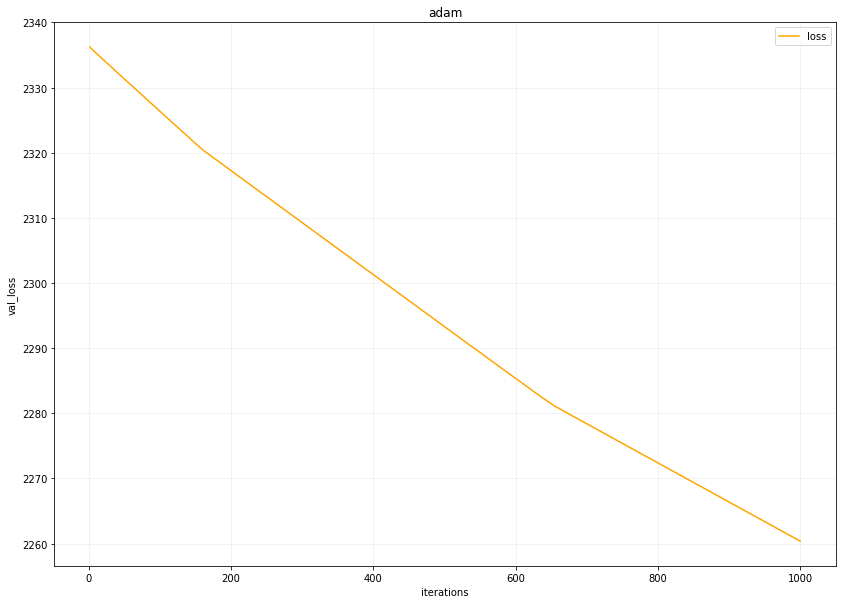

mse on test: 2160.8843543804837, r2 on test: -0.005621382032500621


In [120]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

In [121]:
linreg = LinearRegression(r1=0.01, optimizer='adam')
linreg.fit(X_train, y_train, max_iter=max_iter)

iter_num: 0	mse: 2305.5645344491127,r2: -0.051414792123465114 ,r2_inverse: 1.0514147921234651
iter_num: 1	mse: 5392.2533324404385,r2: -1.4590484594522892 ,r2_inverse: 2.4590484594522892
iter_num: 2	mse: 5390.517822315181,r2: -1.4582570085992286 ,r2_inverse: 2.4582570085992286
iter_num: 3	mse: 5389.291887386206,r2: -1.4576979411347333 ,r2_inverse: 2.4576979411347333
iter_num: 4	mse: 5388.221083535207,r2: -1.457209618647299 ,r2_inverse: 2.457209618647299
iter_num: 5	mse: 5387.213789329537,r2: -1.4567502586892331 ,r2_inverse: 2.456750258689233
iter_num: 6	mse: 5386.235439706668,r2: -1.4563040984321756 ,r2_inverse: 2.4563040984321756
iter_num: 7	mse: 5385.270902843995,r2: -1.4558642372572614 ,r2_inverse: 2.4558642372572614
iter_num: 8	mse: 5384.313088973873,r2: -1.4554274419925446 ,r2_inverse: 2.4554274419925446
iter_num: 9	mse: 5383.358566474136,r2: -1.4549921477031664 ,r2_inverse: 2.4549921477031664
iter_num: 10	mse: 5382.405647955609,r2: -1.4545575848830428 ,r2_inverse: 2.45455758488304

iter_num: 125	mse: 5281.1073182718155,r2: -1.4083621474292007 ,r2_inverse: 2.4083621474292007
iter_num: 126	mse: 5280.225662046113,r2: -1.407960082605848 ,r2_inverse: 2.407960082605848
iter_num: 127	mse: 5279.391034360557,r2: -1.4075794643748694 ,r2_inverse: 2.4075794643748694
iter_num: 128	mse: 5278.588056020852,r2: -1.407213279307609 ,r2_inverse: 2.407213279307609
iter_num: 129	mse: 5277.895721966213,r2: -1.4068975517470652 ,r2_inverse: 2.406897551747065
iter_num: 130	mse: 5277.140765972763,r2: -1.4065532664811116 ,r2_inverse: 2.4065532664811116
iter_num: 131	mse: 5276.298094532714,r2: -1.4061689800281711 ,r2_inverse: 2.406168980028171
iter_num: 132	mse: 5275.513819644086,r2: -1.405811324362206 ,r2_inverse: 2.405811324362206
iter_num: 133	mse: 5274.735587127556,r2: -1.4054564242206724 ,r2_inverse: 2.4054564242206724
iter_num: 134	mse: 5274.282955416087,r2: -1.4052500089719508 ,r2_inverse: 2.405250008971951
iter_num: 135	mse: 5273.35146527495,r2: -1.404825218210957 ,r2_inverse: 2.4048

iter_num: 229	mse: 5211.834212468,r2: -1.3767712866876392 ,r2_inverse: 2.376771286687639
iter_num: 230	mse: 5211.250034914853,r2: -1.376504882121023 ,r2_inverse: 2.376504882121023
iter_num: 231	mse: 5210.664585270743,r2: -1.3762378974382425 ,r2_inverse: 2.3762378974382425
iter_num: 232	mse: 5210.08053004726,r2: -1.375971548658058 ,r2_inverse: 2.375971548658058
iter_num: 233	mse: 5209.495181204225,r2: -1.3757046099439498 ,r2_inverse: 2.37570460994395
iter_num: 234	mse: 5208.911235894697,r2: -1.375438311288217 ,r2_inverse: 2.375438311288217
iter_num: 235	mse: 5208.325976821475,r2: -1.3751714135121555 ,r2_inverse: 2.3751714135121555
iter_num: 236	mse: 5207.742130168791,r2: -1.3749051598472541 ,r2_inverse: 2.374905159847254
iter_num: 237	mse: 5207.156950837241,r2: -1.374638298436071 ,r2_inverse: 2.374638298436071
iter_num: 238	mse: 5206.5731925293385,r2: -1.3743720850593544 ,r2_inverse: 2.3743720850593544
iter_num: 239	mse: 5205.988083807944,r2: -1.374105255848772 ,r2_inverse: 2.3741052558

iter_num: 349	mse: 5141.71292168237,r2: -1.3447936251330823 ,r2_inverse: 2.3447936251330823
iter_num: 350	mse: 5141.128739431612,r2: -1.3445272184241985 ,r2_inverse: 2.3445272184241985
iter_num: 351	mse: 5140.54284731062,r2: -1.3442600319571119 ,r2_inverse: 2.344260031957112
iter_num: 352	mse: 5139.958629916973,r2: -1.343993609221891 ,r2_inverse: 2.343993609221891
iter_num: 353	mse: 5139.372699168237,r2: -1.343726405139257 ,r2_inverse: 2.343726405139257
iter_num: 354	mse: 5138.788446401505,r2: -1.343459966272722 ,r2_inverse: 2.343459966272722
iter_num: 355	mse: 5138.202476795198,r2: -1.3431927444697318 ,r2_inverse: 2.343192744469732
iter_num: 356	mse: 5137.6181884339585,r2: -1.3429262893709075 ,r2_inverse: 2.3429262893709075
iter_num: 357	mse: 5137.032179747442,r2: -1.3426590497460302 ,r2_inverse: 2.3426590497460302
iter_num: 358	mse: 5136.447855578516,r2: -1.3423925783176993 ,r2_inverse: 2.3423925783176993
iter_num: 359	mse: 5135.861807595869,r2: -1.3421253207724684 ,r2_inverse: 2.342

iter_num: 487	mse: 5060.787664534292,r2: -1.3078889923845507 ,r2_inverse: 2.3078889923845507
iter_num: 488	mse: 5060.200728539925,r2: -1.3076213298761772 ,r2_inverse: 2.307621329876177
iter_num: 489	mse: 5059.611788830588,r2: -1.3073527536065424 ,r2_inverse: 2.3073527536065424
iter_num: 490	mse: 5059.024809487128,r2: -1.3070850713295274 ,r2_inverse: 2.3070850713295274
iter_num: 491	mse: 5058.435820662131,r2: -1.3068164726615032 ,r2_inverse: 2.3068164726615032
iter_num: 492	mse: 5057.848797897182,r2: -1.306548770582833 ,r2_inverse: 2.306548770582833
iter_num: 493	mse: 5057.259759816922,r2: -1.306280149452756 ,r2_inverse: 2.306280149452756
iter_num: 494	mse: 5056.672693559409,r2: -1.3060124275400171 ,r2_inverse: 2.306012427540017
iter_num: 495	mse: 5056.083606084224,r2: -1.3057437838841968 ,r2_inverse: 2.3057437838841968
iter_num: 496	mse: 5055.496496264482,r2: -1.3054760421056195 ,r2_inverse: 2.3054760421056195
iter_num: 497	mse: 5054.907359254655,r2: -1.3052073758603404 ,r2_inverse: 2.

iter_num: 598	mse: 4995.383298509262,r2: -1.2780624067996866 ,r2_inverse: 2.2780624067996866
iter_num: 599	mse: 4994.791471853676,r2: -1.2777925139856885 ,r2_inverse: 2.2777925139856885
iter_num: 600	mse: 4994.202082680804,r2: -1.2775237327455993 ,r2_inverse: 2.2775237327455993
iter_num: 601	mse: 4993.61020156401,r2: -1.277253815095463 ,r2_inverse: 2.277253815095463
iter_num: 602	mse: 4993.0207717277335,r2: -1.2769850153114968 ,r2_inverse: 2.2769850153114968
iter_num: 603	mse: 4992.4288362258385,r2: -1.27671507285993 ,r2_inverse: 2.27671507285993
iter_num: 604	mse: 4991.83936611485,r2: -1.2764462547093438 ,r2_inverse: 2.276446254709344
iter_num: 605	mse: 4991.247376321838,r2: -1.2761762874992053 ,r2_inverse: 2.2761762874992053
iter_num: 606	mse: 4990.657866354804,r2: -1.275907451172925 ,r2_inverse: 2.275907451172925
iter_num: 607	mse: 4990.065822383957,r2: -1.2756374592558761 ,r2_inverse: 2.275637459255876
iter_num: 608	mse: 4989.476273011631,r2: -1.2753686049594597 ,r2_inverse: 2.2753

iter_num: 696	mse: 4937.427984008097,r2: -1.2516328386664957 ,r2_inverse: 2.2516328386664957
iter_num: 697	mse: 4936.835032980445,r2: -1.2513624331011064 ,r2_inverse: 2.2513624331011064
iter_num: 698	mse: 4936.246199074217,r2: -1.2510939050812389 ,r2_inverse: 2.251093905081239
iter_num: 699	mse: 4935.6533856297765,r2: -1.2508235622584114 ,r2_inverse: 2.2508235622584114
iter_num: 700	mse: 4935.06478970008,r2: -1.2505551427638277 ,r2_inverse: 2.2505551427638277
iter_num: 701	mse: 4934.472141214197,r2: -1.2502848751676376 ,r2_inverse: 2.2502848751676376
iter_num: 702	mse: 4933.883819841739,r2: -1.2500165808803674 ,r2_inverse: 2.2500165808803674
iter_num: 703	mse: 4933.29136870803,r2: -1.2497464032833911 ,r2_inverse: 2.249746403283391
iter_num: 704	mse: 4932.703364987354,r2: -1.249478253855993 ,r2_inverse: 2.249478253855993
iter_num: 705	mse: 4932.111149837183,r2: -1.249208183875428 ,r2_inverse: 2.249208183875428
iter_num: 706	mse: 4931.523514955853,r2: -1.248940202651148 ,r2_inverse: 2.24

iter_num: 847	mse: 4869.322763703421,r2: -1.220574572901545 ,r2_inverse: 2.220574572901545
iter_num: 848	mse: 4868.919263125898,r2: -1.2203905630985235 ,r2_inverse: 2.2203905630985235
iter_num: 849	mse: 4868.517745774754,r2: -1.2202074577132787 ,r2_inverse: 2.2202074577132787
iter_num: 850	mse: 4868.114245984268,r2: -1.2200234482691719 ,r2_inverse: 2.220023448269172
iter_num: 851	mse: 4867.712729250549,r2: -1.2198403431654938 ,r2_inverse: 2.219840343165494
iter_num: 852	mse: 4867.309230218599,r2: -1.219656334067305 ,r2_inverse: 2.219656334067305
iter_num: 853	mse: 4866.907714076373,r2: -1.2194732292333677 ,r2_inverse: 2.2194732292333677
iter_num: 854	mse: 4866.50421577594,r2: -1.219289220468775 ,r2_inverse: 2.219289220468775
iter_num: 855	mse: 4866.102700200633,r2: -1.2191061158933714 ,r2_inverse: 2.2191061158933714
iter_num: 856	mse: 4865.699202606126,r2: -1.2189221074507053 ,r2_inverse: 2.2189221074507053
iter_num: 857	mse: 4865.297687574477,r2: -1.2187390031232281 ,r2_inverse: 2.218

iter_num: 948	mse: 4828.6694644194595,r2: -1.2020353042854999 ,r2_inverse: 2.2020353042855
iter_num: 949	mse: 4828.267961566369,r2: -1.2018522055118543 ,r2_inverse: 2.2018522055118543
iter_num: 950	mse: 4827.86448262408,r2: -1.201668205575225 ,r2_inverse: 2.201668205575225
iter_num: 951	mse: 4827.462979901616,r2: -1.2014851068611492 ,r2_inverse: 2.201485106861149
iter_num: 952	mse: 4827.059501210116,r2: -1.201301107038888 ,r2_inverse: 2.201301107038888
iter_num: 953	mse: 4826.6579986158,r2: -1.201118008383252 ,r2_inverse: 2.201118008383252
iter_num: 954	mse: 4826.254520172506,r2: -1.2009340086741815 ,r2_inverse: 2.2009340086741815
iter_num: 955	mse: 4825.8530177039465,r2: -1.2007509100758949 ,r2_inverse: 2.200750910075895
iter_num: 956	mse: 4825.449539506379,r2: -1.2005669104788836 ,r2_inverse: 2.2005669104788836
iter_num: 957	mse: 4825.048037161283,r2: -1.2003838119369004 ,r2_inverse: 2.2003838119369004
iter_num: 958	mse: 4824.644559207078,r2: -1.2001998124508706 ,r2_inverse: 2.200199

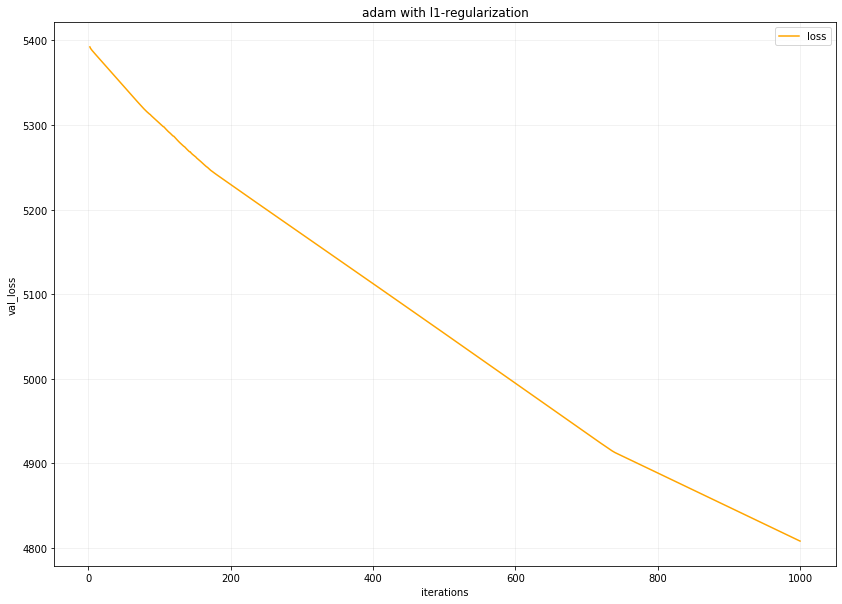

mse on test: 4176.479747907489, r2 on test: -0.9436289256328978


In [122]:
xc = [i for i in range(1, max_iter+1)]
val_loss = linreg.get_losses()
plt.figure(figsize=(14,10))
plt.plot(xc[1:], val_loss[1:], label='loss', c='orange')
plt.xlabel('iterations')
plt.ylabel('val_loss')
plt.grid(alpha=0.2)
plt.title('adam with l1-regularization')
plt.legend()
plt.show()
print(f'mse on test: {mse(y_test, linreg.predict(X_test))}, r2 on test: {r2(y_test, linreg.predict(X_test))}')

Кросс валидация

In [123]:
def cross_validation(X, y, l1_list = [], l2_list = [], optimizer = 'sgd', iter_count = 3, fold_count=5):
    assert len(X) == len(y)
    fold_size = math.ceil(len(X) / fold_count)
    fold_list = []
    for i in range(fold_count):
        fold = {
            'X': [],
            'y_true': [],
            'y_pred': [],
            'mse_train': [],
            'mse_test': [],
            'r2_train': [],
            'r2_test': [],
            'loss': [],
            'l1': [],
            'l2': [],
        }
        min_fold_size = min((i + 1)*fold_size, len(X))
        fold['X'] = X[i*fold_size:min_fold_size]
        fold['y_true'] = y[i*fold_size:min_fold_size]
        fold_list.append(fold)
    for i in range(fold_count):
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        for j in range(fold_count):
            if i != j:
                X_train += fold_list[j]['X']
                y_train += fold_list[j]['y_true']
            else:
                X_test += fold_list[j]['X']
                y_test += fold_list[j]['y_true']
        for l1 in l1_list:
            for l2 in l2_list:
                print('test_fold_num:', i, ' | l1:', l1, ' | l2:', l2)
                model = LinearRegression(optimizer=optimizer, r1=l1, r2=l2)
                model.fit(X_train, y_train, max_iter=iter_count)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                fold_list[i]['y_pred'].append(y_pred_test)
                fold_list[i]['mse_train'].append(mse(y_pred_train, y_train))
                fold_list[i]['mse_test'].append(mse(y_pred_test, y_test))
                fold_list[i]['r2_train'].append(r2(y_pred_train, y_train))
                fold_list[i]['r2_test'].append(r2(y_pred_test, y_test))
                fold_list[i]['loss'].append(model.get_losses())
                fold_list[i]['l1'].append(l1)
                fold_list[i]['l2'].append(l2)
    return fold_list

In [124]:
lst = ['adam']
iter_num = 500
fold_count = 5
for optimizer in lst:
  cv_res = {
    'optimizer': '',
    'res': None,
  }
  cv_res['optimizer'] = optimizer
  cv_res['res'] = cross_validation(X_train, y_train, l1_list=[0.01, 0.1], l2_list=[0.01, 0.1], iter_count = iter_num, optimizer=optimizer, fold_count=fold_count)

test_fold_num: 0  | l1: 0.01  | l2: 0.01
iter_num: 0	mse: 2522.33469702291,r2: -0.047599679097407144 ,r2_inverse: 1.0475996790974071
iter_num: 1	mse: 2528.1973192539117,r2: -0.05003459829156309 ,r2_inverse: 1.050034598291563
iter_num: 2	mse: 2526.7247898989167,r2: -0.04942301360314927 ,r2_inverse: 1.0494230136031493
iter_num: 3	mse: 2525.6224435601825,r2: -0.048965176793436704 ,r2_inverse: 1.0489651767934367
iter_num: 4	mse: 2524.6407444804345,r2: -0.048557448333717224 ,r2_inverse: 1.0485574483337172
iter_num: 5	mse: 2523.7130945791732,r2: -0.04817216808521452 ,r2_inverse: 1.0481721680852145
iter_num: 6	mse: 2522.814194328173,r2: -0.047798828410824834 ,r2_inverse: 1.0477988284108248
iter_num: 7	mse: 2521.9333928139595,r2: -0.04743300567337139 ,r2_inverse: 1.0474330056733714
iter_num: 8	mse: 2521.06639170641,r2: -0.04707291465011498 ,r2_inverse: 1.047072914650115
iter_num: 9	mse: 2520.212059308119,r2: -0.04671808531388599 ,r2_inverse: 1.046718085313886
iter_num: 10	mse: 2519.37114646069

iter_num: 151	mse: 2456.215946053229,r2: -0.02013861995251509 ,r2_inverse: 1.020138619952515
iter_num: 152	mse: 2455.859059593801,r2: -0.019990394524378008 ,r2_inverse: 1.019990394524378
iter_num: 153	mse: 2455.573776700514,r2: -0.019871908160212337 ,r2_inverse: 1.0198719081602123
iter_num: 154	mse: 2455.218311378455,r2: -0.019724272972162726 ,r2_inverse: 1.0197242729721627
iter_num: 155	mse: 2454.93402748938,r2: -0.019606201523786337 ,r2_inverse: 1.0196062015237863
iter_num: 156	mse: 2454.5788692117785,r2: -0.019458693860317622 ,r2_inverse: 1.0194586938603176
iter_num: 157	mse: 2454.2955710743045,r2: -0.019341031823531862 ,r2_inverse: 1.0193410318235319
iter_num: 158	mse: 2453.9418503196507,r2: -0.01919412120556241 ,r2_inverse: 1.0191941212055624
iter_num: 159	mse: 2453.6595019023985,r2: -0.01907685361547773 ,r2_inverse: 1.0190768536154777
iter_num: 160	mse: 2453.305962868251,r2: -0.018930018471371657 ,r2_inverse: 1.0189300184713717
iter_num: 161	mse: 2453.024558727246,r2: -0.01881314

iter_num: 277	mse: 2418.3435476325194,r2: -0.0044091005992696886 ,r2_inverse: 1.0044091005992697
iter_num: 278	mse: 2418.0739622446367,r2: -0.0042971338701243145 ,r2_inverse: 1.0042971338701243
iter_num: 279	mse: 2417.8066302846246,r2: -0.00418610305575573 ,r2_inverse: 1.0041861030557557
iter_num: 280	mse: 2417.459500548655,r2: -0.004041929881419826 ,r2_inverse: 1.0040419298814198
iter_num: 281	mse: 2417.205273886185,r2: -0.0039363420820148765 ,r2_inverse: 1.0039363420820149
iter_num: 282	mse: 2416.93750228766,r2: -0.003825128672859668 ,r2_inverse: 1.0038251286728597
iter_num: 283	mse: 2416.67037512735,r2: -0.0037141829178219954 ,r2_inverse: 1.003714182917822
iter_num: 284	mse: 2416.3236311541523,r2: -0.0035701699620949157 ,r2_inverse: 1.003570169962095
iter_num: 285	mse: 2416.0698052086996,r2: -0.003464748592236111 ,r2_inverse: 1.003464748592236
iter_num: 286	mse: 2415.8038437528767,r2: -0.0033542869885081483 ,r2_inverse: 1.0033542869885081
iter_num: 287	mse: 2415.536902330537,r2: -0.

iter_num: 407	mse: 2382.560734566782,r2: 0.010452552586215136 ,r2_inverse: 0.9895474474137849
iter_num: 408	mse: 2382.1144341727418,r2: 0.010637914247428881 ,r2_inverse: 0.9893620857525711
iter_num: 409	mse: 2381.774889285619,r2: 0.010778937211276318 ,r2_inverse: 0.9892210627887237
iter_num: 410	mse: 2381.493988219203,r2: 0.010895603674050847 ,r2_inverse: 0.9891043963259492
iter_num: 411	mse: 2381.235697009225,r2: 0.011002879599409043 ,r2_inverse: 0.988997120400591
iter_num: 412	mse: 2380.9845409355116,r2: 0.011107192093122276 ,r2_inverse: 0.9888928079068777
iter_num: 413	mse: 2380.7072632325126,r2: 0.011222353666653917 ,r2_inverse: 0.9887776463333461
iter_num: 414	mse: 2380.3805072931145,r2: 0.011358065004907547 ,r2_inverse: 0.9886419349950925
iter_num: 415	mse: 2380.1255491490315,r2: 0.011463956610109571 ,r2_inverse: 0.9885360433898904
iter_num: 416	mse: 2379.8882898845395,r2: 0.011562497350812273 ,r2_inverse: 0.9884375026491877
iter_num: 417	mse: 2379.6654214702867,r2: 0.01165506114

test_fold_num: 0  | l1: 0.01  | l2: 0.1
iter_num: 0	mse: 2522.33469702291,r2: -0.047599679097407144 ,r2_inverse: 1.0475996790974071
iter_num: 1	mse: 2528.450906863871,r2: -0.050139920673691885 ,r2_inverse: 1.0501399206736919
iter_num: 2	mse: 2527.1218886370066,r2: -0.049587940371624395 ,r2_inverse: 1.0495879403716244
iter_num: 3	mse: 2526.1939613847694,r2: -0.049202544931115755 ,r2_inverse: 1.0492025449311158
iter_num: 4	mse: 2525.409901017564,r2: -0.0488769016332431 ,r2_inverse: 1.048876901633243
iter_num: 5	mse: 2524.700940302745,r2: -0.04858244942663714 ,r2_inverse: 1.0485824494266371
iter_num: 6	mse: 2524.041189494481,r2: -0.04830843553948827 ,r2_inverse: 1.0483084355394883
iter_num: 7	mse: 2523.42033446916,r2: -0.04805057621334097 ,r2_inverse: 1.048050576213341
iter_num: 8	mse: 2522.835315784775,r2: -0.0478076007720758 ,r2_inverse: 1.0478076007720758
iter_num: 9	mse: 2522.287436017515,r2: -0.04758005021383993 ,r2_inverse: 1.04758005021384
iter_num: 10	mse: 2521.781712573716,r2: -0

iter_num: 123	mse: 2500.887897516628,r2: -0.03869219338309415 ,r2_inverse: 1.0386921933830942
iter_num: 124	mse: 2500.8655078935185,r2: -0.038682894315047234 ,r2_inverse: 1.0386828943150472
iter_num: 125	mse: 2500.802165051478,r2: -0.038656586172407525 ,r2_inverse: 1.0386565861724075
iter_num: 126	mse: 2500.781243874843,r2: -0.03864789699330862 ,r2_inverse: 1.0386478969933086
iter_num: 127	mse: 2500.7191480563224,r2: -0.03862210677616118 ,r2_inverse: 1.0386221067761612
iter_num: 128	mse: 2500.6996107162554,r2: -0.03861399234503149 ,r2_inverse: 1.0386139923450315
iter_num: 129	mse: 2500.638697491384,r2: -0.03858869329375825 ,r2_inverse: 1.0385886932937582
iter_num: 130	mse: 2500.620466544396,r2: -0.03858112144604253 ,r2_inverse: 1.0385811214460425
iter_num: 131	mse: 2500.5606767166128,r2: -0.03855628897457364 ,r2_inverse: 1.0385562889745736
iter_num: 132	mse: 2500.5436810140554,r2: -0.038549230160147996 ,r2_inverse: 1.038549230160148
iter_num: 133	mse: 2500.484960045411,r2: -0.038524841

iter_num: 221	mse: 2498.458973633753,r2: -0.03768338995853071 ,r2_inverse: 1.0376833899585307
iter_num: 222	mse: 2498.466349059956,r2: -0.037686453189644586 ,r2_inverse: 1.0376864531896446
iter_num: 223	mse: 2498.430822500572,r2: -0.03767169796613912 ,r2_inverse: 1.0376716979661391
iter_num: 224	mse: 2498.438442501808,r2: -0.03767486277644716 ,r2_inverse: 1.0376748627764472
iter_num: 225	mse: 2498.4031762984296,r2: -0.037660215686437404 ,r2_inverse: 1.0376602156864374
iter_num: 226	mse: 2498.4110352396015,r2: -0.037663479735518424 ,r2_inverse: 1.0376634797355184
iter_num: 227	mse: 2498.376023952424,r2: -0.03764893851969342 ,r2_inverse: 1.0376489385196934
iter_num: 228	mse: 2498.3841163917973,r2: -0.0376522995474351 ,r2_inverse: 1.037652299547435
iter_num: 229	mse: 2498.349354742152,r2: -0.03763786201340924 ,r2_inverse: 1.0376378620134092
iter_num: 230	mse: 2498.3576754217615,r2: -0.0376413178360242 ,r2_inverse: 1.0376413178360242
iter_num: 231	mse: 2498.3231582849717,r2: -0.03762698185

iter_num: 315	mse: 2497.547306926681,r2: -0.03730474799999128 ,r2_inverse: 1.0373047479999913
iter_num: 316	mse: 2497.5621120707956,r2: -0.03731089701116019 ,r2_inverse: 1.0373108970111602
iter_num: 317	mse: 2497.534707330861,r2: -0.03729951501780482 ,r2_inverse: 1.0372995150178048
iter_num: 318	mse: 2497.549610304607,r2: -0.03730570466049277 ,r2_inverse: 1.0373057046604928
iter_num: 319	mse: 2497.5223146100016,r2: -0.03729436795686536 ,r2_inverse: 1.0372943679568654
iter_num: 320	mse: 2497.537313733853,r2: -0.03730059753351589 ,r2_inverse: 1.037300597533516
iter_num: 321	mse: 2497.510125240493,r2: -0.03728930535371422 ,r2_inverse: 1.0372893053537142
iter_num: 322	mse: 2497.525218867743,r2: -0.03729557418040175 ,r2_inverse: 1.0372955741804017
iter_num: 323	mse: 2497.498135765706,r2: -0.03728432577271157 ,r2_inverse: 1.0372843257727116
iter_num: 324	mse: 2497.5133222815853,r2: -0.03729063317877501 ,r2_inverse: 1.037290633178775
iter_num: 325	mse: 2497.486342794334,r2: -0.037279427805348

iter_num: 444	mse: 2497.063023357845,r2: -0.037103610810742316 ,r2_inverse: 1.0371036108107423
iter_num: 445	mse: 2497.039939034669,r2: -0.037094023213354754 ,r2_inverse: 1.0370940232133548
iter_num: 446	mse: 2497.0586434353586,r2: -0.03710179170029804 ,r2_inverse: 1.037101791700298
iter_num: 447	mse: 2497.035596823073,r2: -0.03709221976535093 ,r2_inverse: 1.037092219765351
iter_num: 448	mse: 2497.054334412311,r2: -0.03710000203647312 ,r2_inverse: 1.0371000020364731
iter_num: 449	mse: 2497.031324898697,r2: -0.03709044550969387 ,r2_inverse: 1.0370904455096939
iter_num: 450	mse: 2497.050095139468,r2: -0.037098241341956495 ,r2_inverse: 1.0370982413419565
iter_num: 451	mse: 2497.027122122345,r2: -0.03708869997324182 ,r2_inverse: 1.0370886999732418
iter_num: 452	mse: 2497.0459244864123,r2: -0.03709650914725304 ,r2_inverse: 1.037096509147253
iter_num: 453	mse: 2497.0229873734643,r2: -0.037086982690596626 ,r2_inverse: 1.0370869826905966
iter_num: 454	mse: 2497.04182134125,r2: -0.0370948049905

iter_num: 76	mse: 2502.9455394952242,r2: -0.039546792528488695 ,r2_inverse: 1.0395467925284887
iter_num: 77	mse: 2502.736367453965,r2: -0.03945991723649911 ,r2_inverse: 1.039459917236499
iter_num: 78	mse: 2502.5421629771663,r2: -0.03937925841361811 ,r2_inverse: 1.0393792584136181
iter_num: 79	mse: 2502.371810174976,r2: -0.03930850589171131 ,r2_inverse: 1.0393085058917113
iter_num: 80	mse: 2502.191413376035,r2: -0.039233581802967654 ,r2_inverse: 1.0392335818029677
iter_num: 81	mse: 2502.0276951059905,r2: -0.03916558479711285 ,r2_inverse: 1.0391655847971129
iter_num: 82	mse: 2501.8473378691774,r2: -0.03909067713968306 ,r2_inverse: 1.039090677139683
iter_num: 83	mse: 2501.690183057441,r2: -0.03902540613082839 ,r2_inverse: 1.0390254061308284
iter_num: 84	mse: 2501.5202893722762,r2: -0.03895484429370599 ,r2_inverse: 1.038954844293706
iter_num: 85	mse: 2501.375893693883,r2: -0.038894872527656776 ,r2_inverse: 1.0388948725276568
iter_num: 86	mse: 2501.214279149303,r2: -0.03882774926077248 ,r2_

iter_num: 233	mse: 2487.5309228990836,r2: -0.033144649538271675 ,r2_inverse: 1.0331446495382717
iter_num: 234	mse: 2487.4202094404527,r2: -0.03309866698731567 ,r2_inverse: 1.0330986669873157
iter_num: 235	mse: 2487.379878632263,r2: -0.03308191641818348 ,r2_inverse: 1.0330819164181835
iter_num: 236	mse: 2487.2662530940606,r2: -0.033034724395055504 ,r2_inverse: 1.0330347243950555
iter_num: 237	mse: 2487.2262549819166,r2: -0.03301811200436222 ,r2_inverse: 1.0330181120043622
iter_num: 238	mse: 2487.1160604469774,r2: -0.032972344977656 ,r2_inverse: 1.032972344977656
iter_num: 239	mse: 2487.076159358629,r2: -0.032955772883794365 ,r2_inverse: 1.0329557728837944
iter_num: 240	mse: 2486.9623876925866,r2: -0.03290852016948298 ,r2_inverse: 1.032908520169483
iter_num: 241	mse: 2486.9228148667175,r2: -0.032892084412669886 ,r2_inverse: 1.0328920844126699
iter_num: 242	mse: 2486.813214469297,r2: -0.032846564148724555 ,r2_inverse: 1.0328465641487246
iter_num: 243	mse: 2486.7737217703743,r2: -0.0328301

iter_num: 392	mse: 2475.96503924502,r2: -0.02834099837382631 ,r2_inverse: 1.0283409983738263
iter_num: 393	mse: 2475.9223367147,r2: -0.028323262758837453 ,r2_inverse: 1.0283232627588375
iter_num: 394	mse: 2475.8723648678256,r2: -0.028302507983187786 ,r2_inverse: 1.0283025079831878
iter_num: 395	mse: 2475.8158191499156,r2: -0.028279022885826732 ,r2_inverse: 1.0282790228858267
iter_num: 396	mse: 2475.6795630211996,r2: -0.028222431713812002 ,r2_inverse: 1.028222431713812
iter_num: 397	mse: 2475.636491997188,r2: -0.028204543052570363 ,r2_inverse: 1.0282045430525704
iter_num: 398	mse: 2475.5873981486557,r2: -0.02818415293541876 ,r2_inverse: 1.0281841529354188
iter_num: 399	mse: 2475.530374852521,r2: -0.02816046948579487 ,r2_inverse: 1.0281604694857949
iter_num: 400	mse: 2475.3937524964686,r2: -0.028103726208811297 ,r2_inverse: 1.0281037262088113
iter_num: 401	mse: 2475.3502914507685,r2: -0.02808567556010777 ,r2_inverse: 1.0280856755601078
iter_num: 402	mse: 2475.3020813663907,r2: -0.0280656

iter_num: 59	mse: 2521.372929231958,r2: -0.04720022868729434 ,r2_inverse: 1.0472002286872943
iter_num: 60	mse: 2521.4055808350367,r2: -0.04721378985701041 ,r2_inverse: 1.0472137898570104
iter_num: 61	mse: 2521.9145654542135,r2: -0.0474251861179209 ,r2_inverse: 1.047425186117921
iter_num: 62	mse: 2521.5561709291273,r2: -0.04727633434582512 ,r2_inverse: 1.0472763343458251
iter_num: 63	mse: 2521.4193273925403,r2: -0.047219499206069715 ,r2_inverse: 1.0472194992060697
iter_num: 64	mse: 2521.293035560337,r2: -0.04716704649904191 ,r2_inverse: 1.047167046499042
iter_num: 65	mse: 2521.160563239786,r2: -0.047112026853686206 ,r2_inverse: 1.0471120268536862
iter_num: 66	mse: 2521.140659417093,r2: -0.04710376021155893 ,r2_inverse: 1.047103760211559
iter_num: 67	mse: 2521.445551708951,r2: -0.04723039093486725 ,r2_inverse: 1.0472303909348673
iter_num: 68	mse: 2521.362768062791,r2: -0.04719600845531202 ,r2_inverse: 1.047196008455312
iter_num: 69	mse: 2521.278941568903,r2: -0.04716119285046738 ,r2_inve

iter_num: 147	mse: 2522.366227445252,r2: -0.04761277460783497 ,r2_inverse: 1.047612774607835
iter_num: 148	mse: 2522.444967454686,r2: -0.04764547764629845 ,r2_inverse: 1.0476454776462985
iter_num: 149	mse: 2522.4389358871535,r2: -0.04764297255915895 ,r2_inverse: 1.047642972559159
iter_num: 150	mse: 2522.5172786910975,r2: -0.04767551062651698 ,r2_inverse: 1.047675510626517
iter_num: 151	mse: 2522.5108148005847,r2: -0.04767282598294642 ,r2_inverse: 1.0476728259829464
iter_num: 152	mse: 2522.588723495318,r2: -0.04770518375199995 ,r2_inverse: 1.047705183752
iter_num: 153	mse: 2522.5817232762915,r2: -0.047702276355445994 ,r2_inverse: 1.047702276355446
iter_num: 154	mse: 2522.6592060582234,r2: -0.04773445723040437 ,r2_inverse: 1.0477344572304044
iter_num: 155	mse: 2522.6517467706976,r2: -0.04773135916922011 ,r2_inverse: 1.0477313591692201
iter_num: 156	mse: 2522.7287774004417,r2: -0.04776335225209505 ,r2_inverse: 1.047763352252095
iter_num: 157	mse: 2522.7207866074436,r2: -0.0477600334410783

iter_num: 299	mse: 2525.5303364753418,r2: -0.04892692201597382 ,r2_inverse: 1.0489269220159738
iter_num: 300	mse: 2525.5820549332084,r2: -0.04894840221046515 ,r2_inverse: 1.0489484022104651
iter_num: 301	mse: 2525.548879698751,r2: -0.04893462356125888 ,r2_inverse: 1.0489346235612589
iter_num: 302	mse: 2525.6004116562553,r2: -0.048956026296672395 ,r2_inverse: 1.0489560262966724
iter_num: 303	mse: 2525.5670582844073,r2: -0.04894217366177567 ,r2_inverse: 1.0489421736617757
iter_num: 304	mse: 2525.618407248495,r2: -0.048963500394648696 ,r2_inverse: 1.0489635003946487
iter_num: 305	mse: 2525.584879127794,r2: -0.04894957518142129 ,r2_inverse: 1.0489495751814213
iter_num: 306	mse: 2525.636048545899,r2: -0.04897082734357494 ,r2_inverse: 1.048970827343575
iter_num: 307	mse: 2525.6023490056914,r2: -0.04895683093479164 ,r2_inverse: 1.0489568309347916
iter_num: 308	mse: 2525.653342266308,r2: -0.0489780099335666 ,r2_inverse: 1.0489780099335666
iter_num: 309	mse: 2525.6194745773537,r2: -0.0489639436

iter_num: 390	mse: 2526.1318063015615,r2: -0.04917673009960288 ,r2_inverse: 1.0491767300996029
iter_num: 391	mse: 2526.0932433866806,r2: -0.04916071378848352 ,r2_inverse: 1.0491607137884835
iter_num: 392	mse: 2526.139224720021,r2: -0.0491798111866637 ,r2_inverse: 1.0491798111866637
iter_num: 393	mse: 2526.100588288784,r2: -0.04916376434204239 ,r2_inverse: 1.0491637643420424
iter_num: 394	mse: 2526.1464936099533,r2: -0.04918283017013514 ,r2_inverse: 1.0491828301701351
iter_num: 395	mse: 2526.1077851188043,r2: -0.04916675339691623 ,r2_inverse: 1.0491667533969162
iter_num: 396	mse: 2526.153615923929,r2: -0.049185788276307374 ,r2_inverse: 1.0491857882763074
iter_num: 397	mse: 2526.1148368012264,r2: -0.04916968216772988 ,r2_inverse: 1.0491696821677299
iter_num: 398	mse: 2526.1605945577753,r2: -0.049188686707901885 ,r2_inverse: 1.0491886867079019
iter_num: 399	mse: 2526.1217462043237,r2: -0.04917255184576108 ,r2_inverse: 1.049172551845761
iter_num: 400	mse: 2526.1674323516263,r2: -0.04919152

iter_num: 484	mse: 2526.358010208833,r2: -0.04927067922576289 ,r2_inverse: 1.049270679225763
iter_num: 485	mse: 2526.317191252464,r2: -0.04925372591435506 ,r2_inverse: 1.049253725914355
iter_num: 486	mse: 2526.360833787337,r2: -0.04927185194084238 ,r2_inverse: 1.0492718519408424
iter_num: 487	mse: 2526.319986421628,r2: -0.04925488683020118 ,r2_inverse: 1.0492548868302012
iter_num: 488	mse: 2526.363599386507,r2: -0.049273000575401404 ,r2_inverse: 1.0492730005754014
iter_num: 489	mse: 2526.3227241861155,r2: -0.04925602390419925 ,r2_inverse: 1.0492560239041993
iter_num: 490	mse: 2526.3663081745826,r2: -0.04927412561464495 ,r2_inverse: 1.049274125614645
iter_num: 491	mse: 2526.3254057027825,r2: -0.0492571376168256 ,r2_inverse: 1.0492571376168256
iter_num: 492	mse: 2526.3689612967128,r2: -0.04927522753418612 ,r2_inverse: 1.0492752275341861
iter_num: 493	mse: 2526.3280321055763,r2: -0.04925822843904193 ,r2_inverse: 1.049258228439042
iter_num: 494	mse: 2526.3715598753643,r2: -0.04927630680021

iter_num: 100	mse: 2324.0718746999128,r2: -0.0285362965798297 ,r2_inverse: 1.0285362965798297
iter_num: 101	mse: 2323.912279940918,r2: -0.02846566666336403 ,r2_inverse: 1.028465666663364
iter_num: 102	mse: 2323.7371300149935,r2: -0.028388152685367984 ,r2_inverse: 1.028388152685368
iter_num: 103	mse: 2323.579287650963,r2: -0.02831829830508381 ,r2_inverse: 1.0283182983050838
iter_num: 104	mse: 2323.405353304858,r2: -0.028241322291502557 ,r2_inverse: 1.0282413222915026
iter_num: 105	mse: 2323.249152922387,r2: -0.02817219458307818 ,r2_inverse: 1.0281721945830782
iter_num: 106	mse: 2323.0763682342954,r2: -0.028095727359697564 ,r2_inverse: 1.0280957273596976
iter_num: 107	mse: 2322.92169463694,r2: -0.028027275342040747 ,r2_inverse: 1.0280272753420407
iter_num: 108	mse: 2322.7499727220156,r2: -0.027951278457288176 ,r2_inverse: 1.0279512784572882
iter_num: 109	mse: 2322.5967347348515,r2: -0.027883461780218832 ,r2_inverse: 1.0278834617802188
iter_num: 110	mse: 2322.4260155989973,r2: -0.02780790

iter_num: 244	mse: 2303.314552402214,r2: -0.019349980254846688 ,r2_inverse: 1.0193499802548467
iter_num: 245	mse: 2303.1953116230507,r2: -0.019297209309706576 ,r2_inverse: 1.0192972093097066
iter_num: 246	mse: 2303.051397683222,r2: -0.019233519063157622 ,r2_inverse: 1.0192335190631576
iter_num: 247	mse: 2302.932386988464,r2: -0.01918084994368119 ,r2_inverse: 1.0191808499436812
iter_num: 248	mse: 2302.7886851795492,r2: -0.01911725357733718 ,r2_inverse: 1.0191172535773372
iter_num: 249	mse: 2302.669902060179,r2: -0.01906468517313975 ,r2_inverse: 1.0190646851731398
iter_num: 250	mse: 2302.526410412427,r2: -0.019001181815272217 ,r2_inverse: 1.0190011818152722
iter_num: 251	mse: 2302.4078524210295,r2: -0.018948713043230647 ,r2_inverse: 1.0189487130432306
iter_num: 252	mse: 2302.2645690065624,r2: -0.018885301840641855 ,r2_inverse: 1.0188853018406419
iter_num: 253	mse: 2302.146233754766,r2: -0.01883293164376343 ,r2_inverse: 1.0188329316437634
iter_num: 254	mse: 2302.003156685958,r2: -0.018769

iter_num: 360	mse: 2288.6749621580793,r2: -0.01287111439141797 ,r2_inverse: 1.012871114391418
iter_num: 361	mse: 2288.5661218757186,r2: -0.012822946267980528 ,r2_inverse: 1.0128229462679805
iter_num: 362	mse: 2288.432094909009,r2: -0.01276363157918703 ,r2_inverse: 1.012763631579187
iter_num: 363	mse: 2288.323395135681,r2: -0.012715525639127812 ,r2_inverse: 1.0127155256391278
iter_num: 364	mse: 2288.1895053372887,r2: -0.012656271655252516 ,r2_inverse: 1.0126562716552525
iter_num: 365	mse: 2288.080945045688,r2: -0.01260822744392942 ,r2_inverse: 1.0126082274439294
iter_num: 366	mse: 2287.9471914979317,r2: -0.012549033758845196 ,r2_inverse: 1.0125490337588452
iter_num: 367	mse: 2287.8387696689815,r2: -0.012501050825257431 ,r2_inverse: 1.0125010508252574
iter_num: 368	mse: 2287.705151460289,r2: -0.012441917035541206 ,r2_inverse: 1.0124419170355412
iter_num: 369	mse: 2287.596867082886,r2: -0.012393994932217378 ,r2_inverse: 1.0123939949322174
iter_num: 370	mse: 2287.463383307606,r2: -0.012334

iter_num: 27	mse: 2360.2012782175925,r2: -0.044525648413671126 ,r2_inverse: 1.0445256484136711
iter_num: 28	mse: 2359.8133287903715,r2: -0.04435395834182865 ,r2_inverse: 1.0443539583418286
iter_num: 29	mse: 2359.422356643544,r2: -0.0441809305416383 ,r2_inverse: 1.0441809305416383
iter_num: 30	mse: 2359.0699290355196,r2: -0.04402496093040709 ,r2_inverse: 1.044024960930407
iter_num: 31	mse: 2358.9372647885452,r2: -0.0439662493239561 ,r2_inverse: 1.043966249323956
iter_num: 32	mse: 2358.4073466959007,r2: -0.04373172990206009 ,r2_inverse: 1.04373172990206
iter_num: 33	mse: 2358.1569963508837,r2: -0.04362093538683265 ,r2_inverse: 1.0436209353868326
iter_num: 34	mse: 2357.863064041291,r2: -0.04349085333022984 ,r2_inverse: 1.0434908533302298
iter_num: 35	mse: 2357.5473264375833,r2: -0.04335112116912776 ,r2_inverse: 1.0433511211691278
iter_num: 36	mse: 2357.32764482137,r2: -0.04325389934116863 ,r2_inverse: 1.0432538993411686
iter_num: 37	mse: 2357.065119878494,r2: -0.04313771686185519 ,r2_inve

iter_num: 131	mse: 2344.841990940689,r2: -0.03772827496499853 ,r2_inverse: 1.0377282749649985
iter_num: 132	mse: 2344.8127214093556,r2: -0.037715321503581034 ,r2_inverse: 1.037715321503581
iter_num: 133	mse: 2344.869552503131,r2: -0.03774047255134283 ,r2_inverse: 1.0377404725513428
iter_num: 134	mse: 2344.83888986536,r2: -0.0377269025597089 ,r2_inverse: 1.037726902559709
iter_num: 135	mse: 2344.896282085032,r2: -0.03775230193815182 ,r2_inverse: 1.0377523019381518
iter_num: 136	mse: 2344.865683076701,r2: -0.03773876010622712 ,r2_inverse: 1.0377387601062271
iter_num: 137	mse: 2344.923864485094,r2: -0.037764508746348735 ,r2_inverse: 1.0377645087463487
iter_num: 138	mse: 2344.8920712767276,r2: -0.03775043841180126 ,r2_inverse: 1.0377504384118013
iter_num: 139	mse: 2344.950647380168,r2: -0.037776361727321905 ,r2_inverse: 1.037776361727322
iter_num: 140	mse: 2344.918837368831,r2: -0.03776228395648751 ,r2_inverse: 1.0377622839564875
iter_num: 141	mse: 2344.9779872957583,r2: -0.037788461222107

iter_num: 239	mse: 2345.913180273437,r2: -0.03820233823353769 ,r2_inverse: 1.0382023382335377
iter_num: 240	mse: 2345.868695941795,r2: -0.03818265134251653 ,r2_inverse: 1.0381826513425165
iter_num: 241	mse: 2345.924963015318,r2: -0.038207552778677156 ,r2_inverse: 1.0382075527786772
iter_num: 242	mse: 2345.8803593548537,r2: -0.038187813077746435 ,r2_inverse: 1.0381878130777464
iter_num: 243	mse: 2345.936519808041,r2: -0.03821266732823858 ,r2_inverse: 1.0382126673282386
iter_num: 244	mse: 2345.891811019417,r2: -0.0381928811020138 ,r2_inverse: 1.0381928811020138
iter_num: 245	mse: 2345.947868796685,r2: -0.038217689912469766 ,r2_inverse: 1.0382176899124698
iter_num: 246	mse: 2345.9030462756064,r2: -0.038197853353052036 ,r2_inverse: 1.038197853353052
iter_num: 247	mse: 2345.959001050232,r2: -0.038222616578878155 ,r2_inverse: 1.0382226165788782
iter_num: 248	mse: 2345.9140770520125,r2: -0.03820273510995342 ,r2_inverse: 1.0382027351099534
iter_num: 249	mse: 2345.9699324099684,r2: -0.038227454

iter_num: 342	mse: 2346.2559714421836,r2: -0.03835404316273605 ,r2_inverse: 1.038354043162736
iter_num: 343	mse: 2346.308676776649,r2: -0.038377368323248895 ,r2_inverse: 1.038377368323249
iter_num: 344	mse: 2346.2604787750633,r2: -0.03835603791837072 ,r2_inverse: 1.0383560379183707
iter_num: 345	mse: 2346.3131424647227,r2: -0.03837934464864712 ,r2_inverse: 1.0383793446486471
iter_num: 346	mse: 2346.2649030245875,r2: -0.038357995904812814 ,r2_inverse: 1.0383579959048128
iter_num: 347	mse: 2346.3175258056667,r2: -0.03838128453067502 ,r2_inverse: 1.038381284530675
iter_num: 348	mse: 2346.26924584857,r2: -0.03835991785574033 ,r2_inverse: 1.0383599178557403
iter_num: 349	mse: 2346.3218285041207,r2: -0.03838318872373425 ,r2_inverse: 1.0383831887237343
iter_num: 350	mse: 2346.2735086373195,r2: -0.038361804386445986 ,r2_inverse: 1.038361804386446
iter_num: 351	mse: 2346.3260518803313,r2: -0.038385057812110546 ,r2_inverse: 1.0383850578121105
iter_num: 352	mse: 2346.2776929729016,r2: -0.03836365

iter_num: 430	mse: 2346.392707773803,r2: -0.03841455690229045 ,r2_inverse: 1.0384145569022905
iter_num: 431	mse: 2346.444149536539,r2: -0.038437322859191436 ,r2_inverse: 1.0384373228591914
iter_num: 432	mse: 2346.394697914209,r2: -0.03841543765458777 ,r2_inverse: 1.0384154376545878
iter_num: 433	mse: 2346.4461212891997,r2: -0.038438195473847525 ,r2_inverse: 1.0384381954738475
iter_num: 434	mse: 2346.3966514274457,r2: -0.038416302197243235 ,r2_inverse: 1.0384163021972432
iter_num: 435	mse: 2346.448056752281,r2: -0.038439052028264475 ,r2_inverse: 1.0384390520282645
iter_num: 436	mse: 2346.398568990785,r2: -0.038417150829988644 ,r2_inverse: 1.0384171508299886
iter_num: 437	mse: 2346.4499565983942,r2: -0.038439892820111954 ,r2_inverse: 1.038439892820112
iter_num: 438	mse: 2346.4004512629363,r2: -0.03841798384434103 ,r2_inverse: 1.038417983844341
iter_num: 439	mse: 2346.45182147867,r2: -0.03844071813755301 ,r2_inverse: 1.038440718137553
iter_num: 440	mse: 2346.402298896065,r2: -0.0384188015

iter_num: 97	mse: 2344.0836433021805,r2: -0.03739266225003801 ,r2_inverse: 1.037392662250038
iter_num: 98	mse: 2344.0927921704383,r2: -0.03739671115367904 ,r2_inverse: 1.037396711153679
iter_num: 99	mse: 2344.119088016431,r2: -0.03740834858724851 ,r2_inverse: 1.0374083485872485
iter_num: 100	mse: 2344.134529689677,r2: -0.03741518242125608 ,r2_inverse: 1.037415182421256
iter_num: 101	mse: 2344.16029682482,r2: -0.03742658586967873 ,r2_inverse: 1.0374265858696787
iter_num: 102	mse: 2344.174916228177,r2: -0.03743305580167666 ,r2_inverse: 1.0374330558016767
iter_num: 103	mse: 2344.2048869519986,r2: -0.037446319581347254 ,r2_inverse: 1.0374463195813473
iter_num: 104	mse: 2344.222459776953,r2: -0.03745409657331389 ,r2_inverse: 1.0374540965733139
iter_num: 105	mse: 2344.2532092262395,r2: -0.03746770498406704 ,r2_inverse: 1.037467704984067
iter_num: 106	mse: 2344.271315615417,r2: -0.037475718109079015 ,r2_inverse: 1.037475718109079
iter_num: 107	mse: 2344.3046098992645,r2: -0.03749045275639307 

iter_num: 227	mse: 2349.191873072586,r2: -0.03965334953227195 ,r2_inverse: 1.039653349532272
iter_num: 228	mse: 2349.2262505814842,r2: -0.03966856356935611 ,r2_inverse: 1.039668563569356
iter_num: 229	mse: 2349.283676017911,r2: -0.03969397764813509 ,r2_inverse: 1.039693977648135
iter_num: 230	mse: 2349.318100925605,r2: -0.039709212661929394 ,r2_inverse: 1.0397092126619294
iter_num: 231	mse: 2349.3755968716796,r2: -0.03973465794530773 ,r2_inverse: 1.0397346579453077
iter_num: 232	mse: 2349.410067519372,r2: -0.039749913201698295 ,r2_inverse: 1.0397499132016983
iter_num: 233	mse: 2349.4676314748713,r2: -0.03977538858318286 ,r2_inverse: 1.0397753885831829
iter_num: 234	mse: 2349.5021462590453,r2: -0.03979066337252046 ,r2_inverse: 1.0397906633725205
iter_num: 235	mse: 2349.5597758179947,r2: -0.039816167787328105 ,r2_inverse: 1.039816167787328
iter_num: 236	mse: 2349.5943331879257,r2: -0.03983146142332772 ,r2_inverse: 1.0398314614233277
iter_num: 237	mse: 2349.6520260341154,r2: -0.0398569938

iter_num: 351	mse: 2355.0035214545146,r2: -0.04222534025633018 ,r2_inverse: 1.0422253402563302
iter_num: 352	mse: 2355.0389641950305,r2: -0.042241025720049175 ,r2_inverse: 1.0422410257200492
iter_num: 353	mse: 2355.0980991881747,r2: -0.042267196376606364 ,r2_inverse: 1.0422671963766064
iter_num: 354	mse: 2355.1335408415407,r2: -0.04228288135919844 ,r2_inverse: 1.0422828813591984
iter_num: 355	mse: 2355.192679083898,r2: -0.04230905345372027 ,r2_inverse: 1.0423090534537203
iter_num: 356	mse: 2355.2281193175836,r2: -0.04232473780802182 ,r2_inverse: 1.0423247378080218
iter_num: 357	mse: 2355.2872603945607,r2: -0.04235091115702727 ,r2_inverse: 1.0423509111570273
iter_num: 358	mse: 2355.3226988826436,r2: -0.04236659473879856 ,r2_inverse: 1.0423665947387986
iter_num: 359	mse: 2355.3818423884704,r2: -0.042392769162710175 ,r2_inverse: 1.0423927691627102
iter_num: 360	mse: 2355.4172788114442,r2: -0.0424084518305512 ,r2_inverse: 1.0424084518305512
iter_num: 361	mse: 2355.476424348918,r2: -0.04243

iter_num: 447	mse: 2359.5351721400793,r2: -0.04423085792739001 ,r2_inverse: 1.04423085792739
iter_num: 448	mse: 2359.5702749589996,r2: -0.044246392956132086 ,r2_inverse: 1.044246392956132
iter_num: 449	mse: 2359.62921276372,r2: -0.04427247634540055 ,r2_inverse: 1.0442724763454005
iter_num: 450	mse: 2359.664303745612,r2: -0.04428800613557238 ,r2_inverse: 1.0442880061355724
iter_num: 451	mse: 2359.723231695004,r2: -0.04431408516328794 ,r2_inverse: 1.044314085163288
iter_num: 452	mse: 2359.758310693043,r2: -0.044329609649911283 ,r2_inverse: 1.0443296096499113
iter_num: 453	mse: 2359.8172286123945,r2: -0.044355684238753135 ,r2_inverse: 1.0443556842387531
iter_num: 454	mse: 2359.852295481843,r2: -0.04437120335777367 ,r2_inverse: 1.0443712033577737
iter_num: 455	mse: 2359.9112031990426,r2: -0.04439727343157296 ,r2_inverse: 1.044397273431573
iter_num: 456	mse: 2359.946257797201,r2: -0.044412787119837205 ,r2_inverse: 1.0444127871198372
iter_num: 457	mse: 2360.0051551426773,r2: -0.0444388526035

iter_num: 89	mse: 2364.6666364616954,r2: -0.0465018278430982 ,r2_inverse: 1.0465018278430982
iter_num: 90	mse: 2364.6014123949794,r2: -0.046472962419116026 ,r2_inverse: 1.046472962419116
iter_num: 91	mse: 2364.5334112057426,r2: -0.04644286795770891 ,r2_inverse: 1.046442867957709
iter_num: 92	mse: 2364.461099999752,r2: -0.04641086606447131 ,r2_inverse: 1.0464108660644713
iter_num: 93	mse: 2364.385333073497,r2: -0.04637733481503692 ,r2_inverse: 1.046377334815037
iter_num: 94	mse: 2364.305386893485,r2: -0.04634195400396557 ,r2_inverse: 1.0463419540039656
iter_num: 95	mse: 2364.2238063893583,r2: -0.0463058499098965 ,r2_inverse: 1.0463058499098965
iter_num: 96	mse: 2364.1394489437125,r2: -0.04626851685850597 ,r2_inverse: 1.046268516858506
iter_num: 97	mse: 2364.0551198244452,r2: -0.04623119634317718 ,r2_inverse: 1.0462311963431772
iter_num: 98	mse: 2363.968584458523,r2: -0.04619289943602989 ,r2_inverse: 1.0461928994360299
iter_num: 99	mse: 2363.886195365833,r2: -0.0461564374947292 ,r2_inver

iter_num: 234	mse: 2366.6650089954805,r2: -0.0473862233333846 ,r2_inverse: 1.0473862233333846
iter_num: 235	mse: 2366.7393075459704,r2: -0.047419104741569074 ,r2_inverse: 1.047419104741569
iter_num: 236	mse: 2366.7283708893983,r2: -0.047414264638141024 ,r2_inverse: 1.047414264638141
iter_num: 237	mse: 2366.802096717097,r2: -0.047446892583347555 ,r2_inverse: 1.0474468925833476
iter_num: 238	mse: 2366.7905462053923,r2: -0.04744178081349992 ,r2_inverse: 1.0474417808135
iter_num: 239	mse: 2366.8637082373434,r2: -0.04747415924646181 ,r2_inverse: 1.0474741592464618
iter_num: 240	mse: 2366.851556438223,r2: -0.04746878137213684 ,r2_inverse: 1.0474687813721368
iter_num: 241	mse: 2366.924163251627,r2: -0.04750091408876167 ,r2_inverse: 1.0475009140887617
iter_num: 242	mse: 2366.9114239504643,r2: -0.047495276210784754 ,r2_inverse: 1.0474952762107848
iter_num: 243	mse: 2366.983484559538,r2: -0.047527167200384746 ,r2_inverse: 1.0475271672003847
iter_num: 244	mse: 2366.970169692177,r2: -0.04752127460

iter_num: 326	mse: 2368.6318388424725,r2: -0.04825665935941714 ,r2_inverse: 1.0482566593594171
iter_num: 327	mse: 2368.687924375432,r2: -0.04828148045337288 ,r2_inverse: 1.0482814804533729
iter_num: 328	mse: 2368.6584833295365,r2: -0.048268451086836306 ,r2_inverse: 1.0482684510868363
iter_num: 329	mse: 2368.7143203049222,r2: -0.048293162179681826 ,r2_inverse: 1.0482931621796818
iter_num: 330	mse: 2368.684632551082,r2: -0.04828002363060291 ,r2_inverse: 1.048280023630603
iter_num: 331	mse: 2368.740225589835,r2: -0.04830462676737213 ,r2_inverse: 1.0483046267673721
iter_num: 332	mse: 2368.710295734282,r2: -0.04829138107427533 ,r2_inverse: 1.0482913810742753
iter_num: 333	mse: 2368.7656493686945,r2: -0.04831587826076955 ,r2_inverse: 1.0483158782607696
iter_num: 334	mse: 2368.7354819384354,r2: -0.04830252742711694 ,r2_inverse: 1.048302527427117
iter_num: 335	mse: 2368.79060061846,r2: -0.048326920632697945 ,r2_inverse: 1.048326920632698
iter_num: 336	mse: 2368.760200045202,r2: -0.048313466619

iter_num: 434	mse: 2369.5449255073995,r2: -0.04866075304818129 ,r2_inverse: 1.0486607530481813
iter_num: 435	mse: 2369.592490560141,r2: -0.048681803336567686 ,r2_inverse: 1.0486818033365677
iter_num: 436	mse: 2369.554599739548,r2: -0.048665034455746436 ,r2_inverse: 1.0486650344557464
iter_num: 437	mse: 2369.6020744493553,r2: -0.04868604476215643 ,r2_inverse: 1.0486860447621564
iter_num: 438	mse: 2369.564094064831,r2: -0.04866923624411257 ,r2_inverse: 1.0486692362441126
iter_num: 439	mse: 2369.611480109473,r2: -0.048690207311056 ,r2_inverse: 1.048690207311056
iter_num: 440	mse: 2369.5734118243977,r2: -0.048673359891931556 ,r2_inverse: 1.0486733598919316
iter_num: 441	mse: 2369.6207108505528,r2: -0.048694292448158816 ,r2_inverse: 1.0486942924481588
iter_num: 442	mse: 2369.5825562974765,r2: -0.04867740685045163 ,r2_inverse: 1.0486774068504516
iter_num: 443	mse: 2369.629769921293,r2: -0.04869830161120192 ,r2_inverse: 1.048698301611202
iter_num: 444	mse: 2369.5915307024893,r2: -0.0486813785

iter_num: 97	mse: 1673.903430495028,r2: -0.0353288038317916 ,r2_inverse: 1.0353288038317916
iter_num: 98	mse: 1673.5859172297246,r2: -0.035132418172273416 ,r2_inverse: 1.0351324181722734
iter_num: 99	mse: 1673.2366222374974,r2: -0.03491637514380552 ,r2_inverse: 1.0349163751438055
iter_num: 100	mse: 1672.9314119015726,r2: -0.03472759898966582 ,r2_inverse: 1.0347275989896658
iter_num: 101	mse: 1672.5861165406618,r2: -0.034514029779837196 ,r2_inverse: 1.0345140297798372
iter_num: 102	mse: 1672.2750225110062,r2: -0.03432161449247051 ,r2_inverse: 1.0343216144924705
iter_num: 103	mse: 1671.9302069720757,r2: -0.0341083420581354 ,r2_inverse: 1.0341083420581354
iter_num: 104	mse: 1671.623856548896,r2: -0.03391886074672534 ,r2_inverse: 1.0339188607467253
iter_num: 105	mse: 1671.279388914739,r2: -0.03370580349555219 ,r2_inverse: 1.0337058034955522
iter_num: 106	mse: 1670.9719362598094,r2: -0.03351564044094335 ,r2_inverse: 1.0335156404409434
iter_num: 107	mse: 1670.6292380649902,r2: -0.03330367760

iter_num: 212	mse: 1638.5461885209238,r2: -0.013459937102117125 ,r2_inverse: 1.0134599371021171
iter_num: 213	mse: 1638.2348551776308,r2: -0.01326737379647347 ,r2_inverse: 1.0132673737964735
iter_num: 214	mse: 1637.9665457423444,r2: -0.013101421279959391 ,r2_inverse: 1.0131014212799594
iter_num: 215	mse: 1637.6557183754162,r2: -0.012909170926601599 ,r2_inverse: 1.0129091709266016
iter_num: 216	mse: 1637.3879177425692,r2: -0.012743533110333383 ,r2_inverse: 1.0127435331103334
iter_num: 217	mse: 1637.0775928823725,r2: -0.012551593563252306 ,r2_inverse: 1.0125515935632523
iter_num: 218	mse: 1636.8102979090982,r2: -0.012386268503330244 ,r2_inverse: 1.0123862685033302
iter_num: 219	mse: 1636.5004721404352,r2: -0.012194637650186246 ,r2_inverse: 1.0121946376501862
iter_num: 220	mse: 1636.2336797327512,r2: -0.012029623432946224 ,r2_inverse: 1.0120296234329462
iter_num: 221	mse: 1635.9243496931622,r2: -0.01183829919401913 ,r2_inverse: 1.0118382991940191
iter_num: 222	mse: 1635.6580568043444,r2: 

iter_num: 300	mse: 1613.9253695913594,r2: 0.0017683266957332355 ,r2_inverse: 0.9982316733042668
iter_num: 301	mse: 1613.6335553603953,r2: 0.0019488172026412842 ,r2_inverse: 0.9980511827973587
iter_num: 302	mse: 1613.3851359389118,r2: 0.0021024675135299375 ,r2_inverse: 0.9978975324864701
iter_num: 303	mse: 1613.0937098607387,r2: 0.0022827179434075084 ,r2_inverse: 0.9977172820565925
iter_num: 304	mse: 1612.8456915798395,r2: 0.0024361201441640556 ,r2_inverse: 0.9975638798558359
iter_num: 305	mse: 1612.5546515125275,r2: 0.002616131821819856 ,r2_inverse: 0.9973838681781801
iter_num: 306	mse: 1612.3070323830048,r2: 0.0027692871427925647 ,r2_inverse: 0.9972307128572074
iter_num: 307	mse: 1612.0163761989809,r2: 0.0029490613841552937 ,r2_inverse: 0.9970509386158447
iter_num: 308	mse: 1611.7691542433574,r2: 0.0031019710484366803 ,r2_inverse: 0.9968980289515633
iter_num: 309	mse: 1611.4788798289692,r2: 0.0032815091608251468 ,r2_inverse: 0.9967184908391749
iter_num: 310	mse: 1611.2320530811382,r2:

iter_num: 410	mse: 1585.2827903699683,r2: 0.01948409616229707 ,r2_inverse: 0.9805159038377029
iter_num: 411	mse: 1585.009402157851,r2: 0.019653189961543083 ,r2_inverse: 0.9803468100384569
iter_num: 412	mse: 1584.7802952393602,r2: 0.01979489526398115 ,r2_inverse: 0.9802051047360189
iter_num: 413	mse: 1584.507190023558,r2: 0.019963814026703997 ,r2_inverse: 0.980036185973296
iter_num: 414	mse: 1584.2783846369252,r2: 0.02010533282816951 ,r2_inverse: 0.9798946671718305
iter_num: 415	mse: 1584.0055606093451,r2: 0.020274077672695845 ,r2_inverse: 0.9797259223273042
iter_num: 416	mse: 1583.7770550099751,r2: 0.020415411052241428 ,r2_inverse: 0.9795845889477586
iter_num: 417	mse: 1583.504510362068,r2: 0.020583983097180125 ,r2_inverse: 0.9794160169028199
iter_num: 418	mse: 1583.2763028040545,r2: 0.020725132134668867 ,r2_inverse: 0.9792748678653311
iter_num: 419	mse: 1583.0040357266055,r2: 0.020893532499040357 ,r2_inverse: 0.9791064675009596
iter_num: 420	mse: 1582.7761244625685,r2: 0.0210344982752

iter_num: 124	mse: 1699.8416328823703,r2: -0.05137188467026754 ,r2_inverse: 1.0513718846702675
iter_num: 125	mse: 1699.7746141765772,r2: -0.05133043281872163 ,r2_inverse: 1.0513304328187216
iter_num: 126	mse: 1699.7903204612546,r2: -0.051340147339064446 ,r2_inverse: 1.0513401473390644
iter_num: 127	mse: 1699.7237349462296,r2: -0.051298963421063215 ,r2_inverse: 1.0512989634210632
iter_num: 128	mse: 1699.7402050868363,r2: -0.05130915039521167 ,r2_inverse: 1.0513091503952117
iter_num: 129	mse: 1699.6741153684275,r2: -0.05126827313320281 ,r2_inverse: 1.0512682731332028
iter_num: 130	mse: 1699.6912436968698,r2: -0.05127886720420771 ,r2_inverse: 1.0512788672042077
iter_num: 131	mse: 1699.6256164786264,r2: -0.051238276003947814 ,r2_inverse: 1.0512382760039478
iter_num: 132	mse: 1699.6423214422953,r2: -0.051248608218900316 ,r2_inverse: 1.0512486082189003
iter_num: 133	mse: 1699.579610846739,r2: -0.05120982098380522 ,r2_inverse: 1.0512098209838052
iter_num: 134	mse: 1699.5965337868681,r2: -0.05

iter_num: 250	mse: 1698.1047179396242,r2: -0.05029758251085381 ,r2_inverse: 1.0502975825108538
iter_num: 251	mse: 1698.0555570133206,r2: -0.05026717590429697 ,r2_inverse: 1.050267175904297
iter_num: 252	mse: 1698.0920199326551,r2: -0.05028972864537584 ,r2_inverse: 1.0502897286453758
iter_num: 253	mse: 1698.0429805326607,r2: -0.05025939720425909 ,r2_inverse: 1.050259397204259
iter_num: 254	mse: 1698.079589110121,r2: -0.05028204003658843 ,r2_inverse: 1.0502820400365884
iter_num: 255	mse: 1698.03066874018,r2: -0.050251782216948815 ,r2_inverse: 1.0502517822169488
iter_num: 256	mse: 1698.0674196936338,r2: -0.05027451311049136 ,r2_inverse: 1.0502745131104914
iter_num: 257	mse: 1698.0186159105183,r2: -0.05024432740116347 ,r2_inverse: 1.0502443274011635
iter_num: 258	mse: 1698.0555060364281,r2: -0.05026714437449398 ,r2_inverse: 1.050267144374494
iter_num: 259	mse: 1698.0068164487116,r2: -0.05023702929635321 ,r2_inverse: 1.0502370292963532
iter_num: 260	mse: 1698.0438426200592,r2: -0.0502599304

iter_num: 465	mse: 1697.5149710111345,r2: -0.049932817154075604 ,r2_inverse: 1.0499328171540756
iter_num: 466	mse: 1697.5574611669228,r2: -0.04995909781123031 ,r2_inverse: 1.0499590978112303
iter_num: 467	mse: 1697.5136269923273,r2: -0.04993198586276071 ,r2_inverse: 1.0499319858627607
iter_num: 468	mse: 1697.5561313680987,r2: -0.049958275315140854 ,r2_inverse: 1.0499582753151409
iter_num: 469	mse: 1697.5123105217822,r2: -0.0499311716103672 ,r2_inverse: 1.0499311716103672
iter_num: 470	mse: 1697.5548288204566,r2: -0.0499574696742251 ,r2_inverse: 1.049957469674225
iter_num: 471	mse: 1697.5110210332423,r2: -0.049930374046658565 ,r2_inverse: 1.0499303740466586
iter_num: 472	mse: 1697.553552964042,r2: -0.049956680542145415 ,r2_inverse: 1.0499566805421454
iter_num: 473	mse: 1697.5097579721855,r2: -0.049929592828656943 ,r2_inverse: 1.049929592828657
iter_num: 474	mse: 1697.5523032504843,r2: -0.049955907579727565 ,r2_inverse: 1.0499559075797276
iter_num: 475	mse: 1697.5085207955551,r2: -0.0499

iter_num: 53	mse: 1710.4649946880647,r2: -0.057942557906601744 ,r2_inverse: 1.0579425579066017
iter_num: 54	mse: 1710.0013798942668,r2: -0.05765580674691306 ,r2_inverse: 1.057655806746913
iter_num: 55	mse: 1709.5437967525945,r2: -0.05737278623444464 ,r2_inverse: 1.0573727862344446
iter_num: 56	mse: 1709.0830173042937,r2: -0.05708778876903042 ,r2_inverse: 1.0570877887690304
iter_num: 57	mse: 1708.6289272759702,r2: -0.056806928787928035 ,r2_inverse: 1.056806928787928
iter_num: 58	mse: 1708.171261224681,r2: -0.05652385699489404 ,r2_inverse: 1.056523856994894
iter_num: 59	mse: 1707.7210720060666,r2: -0.056245409710113714 ,r2_inverse: 1.0562454097101137
iter_num: 60	mse: 1707.2669075933347,r2: -0.05596450372138673 ,r2_inverse: 1.0559645037213867
iter_num: 61	mse: 1706.8211492918247,r2: -0.05568879701053775 ,r2_inverse: 1.0556887970105377
iter_num: 62	mse: 1706.3710146712278,r2: -0.05541038349526817 ,r2_inverse: 1.0554103834952682
iter_num: 63	mse: 1705.9304198963243,r2: -0.05513787048587648

iter_num: 191	mse: 1691.6596698411008,r2: -0.046311245057378825 ,r2_inverse: 1.0463112450573788
iter_num: 192	mse: 1691.5883147593643,r2: -0.04626711110671233 ,r2_inverse: 1.0462671111067123
iter_num: 193	mse: 1691.534016847648,r2: -0.0462335272147365 ,r2_inverse: 1.0462335272147365
iter_num: 194	mse: 1691.4628310270946,r2: -0.04618949795408711 ,r2_inverse: 1.046189497954087
iter_num: 195	mse: 1691.4087086011964,r2: -0.04615602260213736 ,r2_inverse: 1.0461560226021374
iter_num: 196	mse: 1691.33768998874,r2: -0.04611209676164707 ,r2_inverse: 1.046112096761647
iter_num: 197	mse: 1691.2837412886488,r2: -0.046078728861136176 ,r2_inverse: 1.0460787288611362
iter_num: 198	mse: 1691.2128902610555,r2: -0.04603490667383903 ,r2_inverse: 1.046034906673839
iter_num: 199	mse: 1691.159114698275,r2: -0.04600164586077504 ,r2_inverse: 1.046001645860775
iter_num: 200	mse: 1691.088429885414,r2: -0.04595792647922914 ,r2_inverse: 1.0459579264792291
iter_num: 201	mse: 1691.0348270446575,r2: -0.0459247724967

iter_num: 306	mse: 1684.872552865154,r2: -0.04211333401176032 ,r2_inverse: 1.0421133340117603
iter_num: 307	mse: 1684.8386907272022,r2: -0.04209238988431441 ,r2_inverse: 1.0420923898843144
iter_num: 308	mse: 1684.7633905707207,r2: -0.04204581585888478 ,r2_inverse: 1.0420458158588848
iter_num: 309	mse: 1684.72967395172,r2: -0.04202496173660797 ,r2_inverse: 1.042024961736608
iter_num: 310	mse: 1684.6545115113818,r2: -0.041978472890220164 ,r2_inverse: 1.0419784728902202
iter_num: 311	mse: 1684.6209400098971,r2: -0.04195770852482017 ,r2_inverse: 1.0419577085248202
iter_num: 312	mse: 1684.5459148539594,r2: -0.041911304590435794 ,r2_inverse: 1.0419113045904358
iter_num: 313	mse: 1684.5124880711232,r2: -0.04189062973520863 ,r2_inverse: 1.0418906297352086
iter_num: 314	mse: 1684.4375997709928,r2: -0.041844310447738176 ,r2_inverse: 1.0418443104477382
iter_num: 315	mse: 1684.4043173104462,r2: -0.041823724857531275 ,r2_inverse: 1.0418237248575313
iter_num: 316	mse: 1684.3295654406124,r2: -0.04177

iter_num: 25	mse: 1724.6842400626388,r2: -0.0667373270891316 ,r2_inverse: 1.0667373270891316
iter_num: 26	mse: 1724.2752485399828,r2: -0.06648436106001987 ,r2_inverse: 1.0664843610600199
iter_num: 27	mse: 1723.9080693010462,r2: -0.06625725641627844 ,r2_inverse: 1.0662572564162784
iter_num: 28	mse: 1723.54786066618,r2: -0.06603446317249162 ,r2_inverse: 1.0660344631724916
iter_num: 29	mse: 1723.2399642896612,r2: -0.0658440256709023 ,r2_inverse: 1.0658440256709023
iter_num: 30	mse: 1723.0304326281446,r2: -0.06571442789331794 ,r2_inverse: 1.065714427893318
iter_num: 31	mse: 1722.4834990510285,r2: -0.06537614309393525 ,r2_inverse: 1.0653761430939352
iter_num: 32	mse: 1722.141497008767,r2: -0.06516461084011937 ,r2_inverse: 1.0651646108401194
iter_num: 33	mse: 1721.8165667318924,r2: -0.06496363767239877 ,r2_inverse: 1.0649636376723988
iter_num: 34	mse: 1721.5865401565286,r2: -0.0648213635514534 ,r2_inverse: 1.0648213635514534
iter_num: 35	mse: 1721.2062859927767,r2: -0.06458617191414784 ,r2_i

iter_num: 130	mse: 1720.2642899837526,r2: -0.0640035363908138 ,r2_inverse: 1.0640035363908138
iter_num: 131	mse: 1720.3993181926057,r2: -0.06408705291357641 ,r2_inverse: 1.0640870529135764
iter_num: 132	mse: 1720.3842005021684,r2: -0.06407770244563915 ,r2_inverse: 1.0640777024456392
iter_num: 133	mse: 1720.5070820396024,r2: -0.06415370611039473 ,r2_inverse: 1.0641537061103947
iter_num: 134	mse: 1720.5161441020148,r2: -0.064159311101738 ,r2_inverse: 1.064159311101738
iter_num: 135	mse: 1720.6338267074675,r2: -0.06423209916639916 ,r2_inverse: 1.0642320991663992
iter_num: 136	mse: 1720.62527375905,r2: -0.06422680906800227 ,r2_inverse: 1.0642268090680023
iter_num: 137	mse: 1720.7492618785031,r2: -0.06430349716664896 ,r2_inverse: 1.064303497166649
iter_num: 138	mse: 1720.748663180942,r2: -0.06430312686522144 ,r2_inverse: 1.0643031268652214
iter_num: 139	mse: 1720.8661451643534,r2: -0.06437579084280864 ,r2_inverse: 1.0643757908428086
iter_num: 140	mse: 1720.859198684983,r2: -0.06437149436426

iter_num: 301	mse: 1725.8071217256206,r2: -0.06743184250011658 ,r2_inverse: 1.0674318425001166
iter_num: 302	mse: 1725.7574791689203,r2: -0.06740113799953962 ,r2_inverse: 1.0674011379995396
iter_num: 303	mse: 1725.8338779086857,r2: -0.06744839151154913 ,r2_inverse: 1.0674483915115491
iter_num: 304	mse: 1725.7839911581632,r2: -0.06741753597424349 ,r2_inverse: 1.0674175359742435
iter_num: 305	mse: 1725.8601519871197,r2: -0.06746464233564153 ,r2_inverse: 1.0674646423356415
iter_num: 306	mse: 1725.810025416499,r2: -0.06743363846680683 ,r2_inverse: 1.0674336384668068
iter_num: 307	mse: 1725.8859525407993,r2: -0.06748060027914815 ,r2_inverse: 1.0674806002791482
iter_num: 308	mse: 1725.8355904469609,r2: -0.06744945073645514 ,r2_inverse: 1.0674494507364551
iter_num: 309	mse: 1725.9112880006548,r2: -0.06749627055669749 ,r2_inverse: 1.0674962705566975
iter_num: 310	mse: 1725.860694604948,r2: -0.06746497795109985 ,r2_inverse: 1.0674649779510998
iter_num: 311	mse: 1725.9361666511516,r2: -0.0675116

iter_num: 387	mse: 1726.6119551811298,r2: -0.06792964138361013 ,r2_inverse: 1.0679296413836101
iter_num: 388	mse: 1726.554955666033,r2: -0.06789438651841961 ,r2_inverse: 1.0678943865184196
iter_num: 389	mse: 1726.6241608989992,r2: -0.06793719076253568 ,r2_inverse: 1.0679371907625357
iter_num: 390	mse: 1726.567049632279,r2: -0.06790186677766186 ,r2_inverse: 1.0679018667776619
iter_num: 391	mse: 1726.636145161759,r2: -0.06794460316889195 ,r2_inverse: 1.067944603168892
iter_num: 392	mse: 1726.5789241658779,r2: -0.06790921131525174 ,r2_inverse: 1.0679092113152517
iter_num: 393	mse: 1726.6479119636886,r2: -0.06795188107318717 ,r2_inverse: 1.0679518810731872
iter_num: 394	mse: 1726.5905832248202,r2: -0.06791642257925212 ,r2_inverse: 1.0679164225792521
iter_num: 395	mse: 1726.6594652278254,r2: -0.06795902690186595 ,r2_inverse: 1.067959026901866
iter_num: 396	mse: 1726.602030696496,r2: -0.06792350297405947 ,r2_inverse: 1.0679235029740595
iter_num: 397	mse: 1726.6708088072241,r2: -0.06796604303

iter_num: 96	mse: 2331.071020467022,r2: -0.03309096023913871 ,r2_inverse: 1.0330909602391387
iter_num: 97	mse: 2330.8738199645036,r2: -0.033003564336260505 ,r2_inverse: 1.0330035643362605
iter_num: 98	mse: 2330.6931378106647,r2: -0.03292348908408327 ,r2_inverse: 1.0329234890840833
iter_num: 99	mse: 2330.4985573700164,r2: -0.03283725434798623 ,r2_inverse: 1.0328372543479862
iter_num: 100	mse: 2330.320588245441,r2: -0.03275838146415455 ,r2_inverse: 1.0327583814641546
iter_num: 101	mse: 2330.1284045990424,r2: -0.03267320894643344 ,r2_inverse: 1.0326732089464334
iter_num: 102	mse: 2329.952936678572,r2: -0.03259544455364627 ,r2_inverse: 1.0325954445536463
iter_num: 103	mse: 2329.7629923735262,r2: -0.032511264473859436 ,r2_inverse: 1.0325112644738594
iter_num: 104	mse: 2329.58986832142,r2: -0.03243453884359759 ,r2_inverse: 1.0324345388435976
iter_num: 105	mse: 2329.4020038844633,r2: -0.03235128052591163 ,r2_inverse: 1.0323512805259116
iter_num: 106	mse: 2329.2310581875618,r2: -0.032275520305

iter_num: 310	mse: 2300.3132675262123,r2: -0.019459648176388455 ,r2_inverse: 1.0194596481763885
iter_num: 311	mse: 2300.177942149802,r2: -0.0193996742751934 ,r2_inverse: 1.0193996742751934
iter_num: 312	mse: 2300.063182677884,r2: -0.01934881483247386 ,r2_inverse: 1.0193488148324739
iter_num: 313	mse: 2299.9280408802747,r2: -0.01928892229027568 ,r2_inverse: 1.0192889222902757
iter_num: 314	mse: 2299.813475730192,r2: -0.019238148967682722 ,r2_inverse: 1.0192381489676827
iter_num: 315	mse: 2299.678515977087,r2: -0.019178337104507115 ,r2_inverse: 1.0191783371045071
iter_num: 316	mse: 2299.5641434428085,r2: -0.019127649145957104 ,r2_inverse: 1.019127649145957
iter_num: 317	mse: 2299.429364225573,r2: -0.019067917293202674 ,r2_inverse: 1.0190679172932027
iter_num: 318	mse: 2299.3151826296953,r2: -0.01901731395529893 ,r2_inverse: 1.019017313955299
iter_num: 319	mse: 2299.1805824645303,r2: -0.0189576614553717 ,r2_inverse: 1.0189576614553717
iter_num: 320	mse: 2299.06659015738,r2: -0.01890714200

iter_num: 421	mse: 2286.9216457812518,r2: -0.013524709581129057 ,r2_inverse: 1.013524709581129
iter_num: 422	mse: 2286.815569182634,r2: -0.013477698239920288 ,r2_inverse: 1.0134776982399203
iter_num: 423	mse: 2286.688653069146,r2: -0.013421451180777977 ,r2_inverse: 1.013421451180778
iter_num: 424	mse: 2286.582703657844,r2: -0.01337449620682074 ,r2_inverse: 1.0133744962068207
iter_num: 425	mse: 2286.4559094301635,r2: -0.01331830316539162 ,r2_inverse: 1.0133183031653916
iter_num: 426	mse: 2286.3500862865094,r2: -0.013271404151104393 ,r2_inverse: 1.0132714041511044
iter_num: 427	mse: 2286.223413102122,r2: -0.013215264754000478 ,r2_inverse: 1.0132152647540005
iter_num: 428	mse: 2286.1177153123804,r2: -0.013168421294431853 ,r2_inverse: 1.0131684212944319
iter_num: 429	mse: 2285.991162333529,r2: -0.013112335170373246 ,r2_inverse: 1.0131123351703732
iter_num: 430	mse: 2285.8855889897686,r2: -0.013065546863143318 ,r2_inverse: 1.0130655468631433
iter_num: 431	mse: 2285.759155383314,r2: -0.01300

iter_num: 23	mse: 2363.474870827187,r2: -0.047451794632473066 ,r2_inverse: 1.047451794632473
iter_num: 24	mse: 2363.1333495726276,r2: -0.0473004382311808 ,r2_inverse: 1.0473004382311808
iter_num: 25	mse: 2362.8651967255055,r2: -0.047181597458037405 ,r2_inverse: 1.0471815974580374
iter_num: 26	mse: 2362.541999108814,r2: -0.04703836178085563 ,r2_inverse: 1.0470383617808556
iter_num: 27	mse: 2362.699276199902,r2: -0.047108064307990194 ,r2_inverse: 1.0471080643079902
iter_num: 28	mse: 2362.3264147494065,r2: -0.04694281846582293 ,r2_inverse: 1.046942818465823
iter_num: 29	mse: 2362.077088021236,r2: -0.04683232110784541 ,r2_inverse: 1.0468323211078454
iter_num: 30	mse: 2361.654365484932,r2: -0.04664497768196507 ,r2_inverse: 1.046644977681965
iter_num: 31	mse: 2361.275475410128,r2: -0.0464770600562181 ,r2_inverse: 1.046477060056218
iter_num: 32	mse: 2360.8997606799453,r2: -0.04631054968910697 ,r2_inverse: 1.046310549689107
iter_num: 33	mse: 2360.579960931465,r2: -0.04616881988922472 ,r2_inver

iter_num: 127	mse: 2351.408662171294,r2: -0.0421042565363301 ,r2_inverse: 1.04210425653633
iter_num: 128	mse: 2351.445084554634,r2: -0.042120398316073615 ,r2_inverse: 1.0421203983160736
iter_num: 129	mse: 2351.4205010131254,r2: -0.042109503309323504 ,r2_inverse: 1.0421095033093235
iter_num: 130	mse: 2351.457832111374,r2: -0.04212604781603191 ,r2_inverse: 1.042126047816032
iter_num: 131	mse: 2351.434872795088,r2: -0.04211587263822736 ,r2_inverse: 1.0421158726382274
iter_num: 132	mse: 2351.4730531970627,r2: -0.04213279354187738 ,r2_inverse: 1.0421327935418774
iter_num: 133	mse: 2351.4497728802216,r2: -0.04212247610209596 ,r2_inverse: 1.042122476102096
iter_num: 134	mse: 2351.488607611262,r2: -0.042139686993239334 ,r2_inverse: 1.0421396869932393
iter_num: 135	mse: 2351.466469447093,r2: -0.04212987573606264 ,r2_inverse: 1.0421298757360626
iter_num: 136	mse: 2351.5059393563142,r2: -0.04214736812735409 ,r2_inverse: 1.042147368127354
iter_num: 137	mse: 2351.483609844702,r2: -0.042137472068250

iter_num: 254	mse: 2352.539666326682,r2: -0.04260549830831617 ,r2_inverse: 1.0426054983083162
iter_num: 255	mse: 2352.513665142384,r2: -0.04259397502643503 ,r2_inverse: 1.042593975026435
iter_num: 256	mse: 2352.550853832425,r2: -0.04261045642025252 ,r2_inverse: 1.0426104564202525
iter_num: 257	mse: 2352.524752340668,r2: -0.04259888868381445 ,r2_inverse: 1.0425988886838145
iter_num: 258	mse: 2352.5618418601725,r2: -0.042615326126939745 ,r2_inverse: 1.0426153261269397
iter_num: 259	mse: 2352.5356416608556,r2: -0.04260371464499291 ,r2_inverse: 1.042603714644993
iter_num: 260	mse: 2352.5726335647837,r2: -0.042620108826557646 ,r2_inverse: 1.0426201088265576
iter_num: 261	mse: 2352.546336221686,r2: -0.04260845429214233 ,r2_inverse: 1.0426084542921423
iter_num: 262	mse: 2352.58323205669,r2: -0.042624805897596874 ,r2_inverse: 1.0426248058975969
iter_num: 263	mse: 2352.556839146301,r2: -0.04261310900938642 ,r2_inverse: 1.0426131090093864
iter_num: 264	mse: 2352.5936404516633,r2: -0.042629418720

iter_num: 413	mse: 2352.9798137105067,r2: -0.04280056412973887 ,r2_inverse: 1.0428005641297389
iter_num: 414	mse: 2353.0127282087024,r2: -0.04281515127455271 ,r2_inverse: 1.0428151512745527
iter_num: 415	mse: 2352.9823846868103,r2: -0.04280170354263335 ,r2_inverse: 1.0428017035426334
iter_num: 416	mse: 2353.0152753564116,r2: -0.04281628012701977 ,r2_inverse: 1.0428162801270198
iter_num: 417	mse: 2352.9849082099286,r2: -0.04280282192508422 ,r2_inverse: 1.0428028219250842
iter_num: 418	mse: 2353.0177754901943,r2: -0.04281738814371594 ,r2_inverse: 1.042817388143716
iter_num: 419	mse: 2352.987385154647,r2: -0.04280391966478225 ,r2_inverse: 1.0428039196647823
iter_num: 420	mse: 2353.02022947677,r2: -0.04281847570875619 ,r2_inverse: 1.0428184757087562
iter_num: 421	mse: 2352.9898163796756,r2: -0.042804997142292356 ,r2_inverse: 1.0428049971422924
iter_num: 422	mse: 2353.022638166933,r2: -0.042819543199197785 ,r2_inverse: 1.0428195431991978
iter_num: 423	mse: 2352.992202727971,r2: -0.042806054

iter_num: 2	mse: 2370.052089552589,r2: -0.05036670591105241 ,r2_inverse: 1.0503667059110524
iter_num: 3	mse: 2369.366267524421,r2: -0.05006276127298137 ,r2_inverse: 1.0500627612729814
iter_num: 4	mse: 2368.8211894955944,r2: -0.04982119197746804 ,r2_inverse: 1.049821191977468
iter_num: 5	mse: 2368.345398273807,r2: -0.0496103294143484 ,r2_inverse: 1.0496103294143484
iter_num: 6	mse: 2367.942104994709,r2: -0.04943159670423225 ,r2_inverse: 1.0494315967042323
iter_num: 7	mse: 2367.763529204821,r2: -0.0493524549566704 ,r2_inverse: 1.0493524549566704
iter_num: 8	mse: 2367.1026871428553,r2: -0.04905958101401975 ,r2_inverse: 1.0490595810140197
iter_num: 9	mse: 2366.7762518546533,r2: -0.04891491045598717 ,r2_inverse: 1.0489149104559872
iter_num: 10	mse: 2366.4174777170715,r2: -0.04875590787088835 ,r2_inverse: 1.0487559078708883
iter_num: 11	mse: 2366.108460051907,r2: -0.04861895650662995 ,r2_inverse: 1.04861895650663
iter_num: 12	mse: 2365.7242304095425,r2: -0.04844867247551421 ,r2_inverse: 1.04

iter_num: 218	mse: 2355.3375952421875,r2: -0.04384549273346283 ,r2_inverse: 1.0438454927334628
iter_num: 219	mse: 2355.3946573062285,r2: -0.04387078166804104 ,r2_inverse: 1.043870781668041
iter_num: 220	mse: 2355.4346526990294,r2: -0.0438885069447017 ,r2_inverse: 1.0438885069447017
iter_num: 221	mse: 2355.491855427433,r2: -0.043913858219328805 ,r2_inverse: 1.0439138582193288
iter_num: 222	mse: 2355.531971632873,r2: -0.04393163703809311 ,r2_inverse: 1.043931637038093
iter_num: 223	mse: 2355.589310317063,r2: -0.04395704856600813 ,r2_inverse: 1.0439570485660081
iter_num: 224	mse: 2355.629543150204,r2: -0.043974879072182116 ,r2_inverse: 1.0439748790721821
iter_num: 225	mse: 2355.687013259034,r2: -0.0440003488452585 ,r2_inverse: 1.0440003488452585
iter_num: 226	mse: 2355.7273586923716,r2: -0.04401822925392129 ,r2_inverse: 1.0440182292539213
iter_num: 227	mse: 2355.7849558636826,r2: -0.04404375533892457 ,r2_inverse: 1.0440437553389246
iter_num: 228	mse: 2355.825410019719,r2: -0.0440616839316

iter_num: 318	mse: 2360.390105685413,r2: -0.0460846792788665 ,r2_inverse: 1.0460846792788665
iter_num: 319	mse: 2360.450646632945,r2: -0.04611150999533575 ,r2_inverse: 1.0461115099953358
iter_num: 320	mse: 2360.4935255922273,r2: -0.04613051321953199 ,r2_inverse: 1.046130513219532
iter_num: 321	mse: 2360.554091896139,r2: -0.0461573551735166 ,r2_inverse: 1.0461573551735166
iter_num: 322	mse: 2360.596989362809,r2: -0.046176366599871566 ,r2_inverse: 1.0461763665998716
iter_num: 323	mse: 2360.657580020594,r2: -0.04620321934707783 ,r2_inverse: 1.0462032193470778
iter_num: 324	mse: 2360.7004951128247,r2: -0.04622223858478125 ,r2_inverse: 1.0462222385847813
iter_num: 325	mse: 2360.761109146622,r2: -0.046249101691837824 ,r2_inverse: 1.0462491016918378
iter_num: 326	mse: 2360.804041004615,r2: -0.046268128359841176 ,r2_inverse: 1.0462681283598412
iter_num: 327	mse: 2360.8646774604335,r2: -0.046295001403955816 ,r2_inverse: 1.0462950014039558
iter_num: 328	mse: 2360.9076252457317,r2: -0.04631403513

iter_num: 465	mse: 2368.0338390546463,r2: -0.04947225167666125 ,r2_inverse: 1.0494722516766612
iter_num: 466	mse: 2368.076623144776,r2: -0.049491212856465294 ,r2_inverse: 1.0494912128564653
iter_num: 467	mse: 2368.137348409452,r2: -0.04951812525915256 ,r2_inverse: 1.0495181252591526
iter_num: 468	mse: 2368.1801187056653,r2: -0.04953708032572779 ,r2_inverse: 1.0495370803257278
iter_num: 469	mse: 2368.240832025049,r2: -0.04956398743446466 ,r2_inverse: 1.0495639874344647
iter_num: 470	mse: 2368.2835883228404,r2: -0.049582936297177804 ,r2_inverse: 1.0495829362971778
iter_num: 471	mse: 2368.3442894641908,r2: -0.04960983800881791 ,r2_inverse: 1.049609838008818
iter_num: 472	mse: 2368.3870315622407,r2: -0.049628780578447884 ,r2_inverse: 1.0496287805784479
iter_num: 473	mse: 2368.4477202964554,r2: -0.04965567679145666 ,r2_inverse: 1.0496556767914567
iter_num: 474	mse: 2368.4904479965458,r2: -0.049674612980156185 ,r2_inverse: 1.0496746129801562
iter_num: 475	mse: 2368.5511240980645,r2: -0.04970

iter_num: 57	mse: 2366.4217789551158,r2: -0.04875781410630653 ,r2_inverse: 1.0487578141063065
iter_num: 58	mse: 2366.4759979565683,r2: -0.04878184304398436 ,r2_inverse: 1.0487818430439844
iter_num: 59	mse: 2366.3191927594394,r2: -0.04871234965221305 ,r2_inverse: 1.048712349652213
iter_num: 60	mse: 2366.3131297592454,r2: -0.04870966263382659 ,r2_inverse: 1.0487096626338266
iter_num: 61	mse: 2366.189814790154,r2: -0.04865501154052554 ,r2_inverse: 1.0486550115405255
iter_num: 62	mse: 2366.296791343122,r2: -0.04870242172616912 ,r2_inverse: 1.0487024217261691
iter_num: 63	mse: 2366.19530174766,r2: -0.04865744326660715 ,r2_inverse: 1.0486574432666071
iter_num: 64	mse: 2366.1463474380666,r2: -0.04863574755066313 ,r2_inverse: 1.0486357475506631
iter_num: 65	mse: 2366.0615973342165,r2: -0.04859818774858149 ,r2_inverse: 1.0485981877485815
iter_num: 66	mse: 2366.212559733491,r2: -0.048665091711891595 ,r2_inverse: 1.0486650917118916
iter_num: 67	mse: 2366.1747059398112,r2: -0.04864831555547333 ,r2

iter_num: 214	mse: 2372.9355426546626,r2: -0.051644603198552685 ,r2_inverse: 1.0516446031985527
iter_num: 215	mse: 2373.000439658639,r2: -0.05167336444502113 ,r2_inverse: 1.0516733644450211
iter_num: 216	mse: 2373.013232344759,r2: -0.05167903394555173 ,r2_inverse: 1.0516790339455517
iter_num: 217	mse: 2373.0774379536642,r2: -0.051707488777503974 ,r2_inverse: 1.051707488777504
iter_num: 218	mse: 2373.0895410152725,r2: -0.05171285264820091 ,r2_inverse: 1.051712852648201
iter_num: 219	mse: 2373.1530654860303,r2: -0.051741005611331436 ,r2_inverse: 1.0517410056113314
iter_num: 220	mse: 2373.1644895914937,r2: -0.051746068580232674 ,r2_inverse: 1.0517460685802327
iter_num: 221	mse: 2373.2273432285892,r2: -0.05177392424131355 ,r2_inverse: 1.0517739242413136
iter_num: 222	mse: 2373.2380988681734,r2: -0.051778690957526186 ,r2_inverse: 1.0517786909575262
iter_num: 223	mse: 2373.300291951423,r2: -0.05180625387239668 ,r2_inverse: 1.0518062538723967
iter_num: 224	mse: 2373.310389709489,r2: -0.051810

iter_num: 304	mse: 2375.3384476014326,r2: -0.052709529731046256 ,r2_inverse: 1.0527095297310463
iter_num: 305	mse: 2375.38134874233,r2: -0.05272854278575623 ,r2_inverse: 1.0527285427857562
iter_num: 306	mse: 2375.3722929766213,r2: -0.0527245294246832 ,r2_inverse: 1.0527245294246832
iter_num: 307	mse: 2375.41487911021,r2: -0.052743402873521195 ,r2_inverse: 1.0527434028735212
iter_num: 308	mse: 2375.405511043612,r2: -0.05273925110601496 ,r2_inverse: 1.052739251106015
iter_num: 309	mse: 2375.447787939373,r2: -0.05275798750591609 ,r2_inverse: 1.052757987505916
iter_num: 310	mse: 2375.438113296466,r2: -0.05275369986901324 ,r2_inverse: 1.0527536998690132
iter_num: 311	mse: 2375.4800866222877,r2: -0.05277230173188929 ,r2_inverse: 1.0527723017318893
iter_num: 312	mse: 2375.47011102652,r2: -0.05276788071780625 ,r2_inverse: 1.0527678807178062
iter_num: 313	mse: 2375.5117863501887,r2: -0.052786350511205615 ,r2_inverse: 1.0527863505112056
iter_num: 314	mse: 2375.5015153253216,r2: -0.05278179856797

iter_num: 440	mse: 2376.651076824514,r2: -0.05329126463856482 ,r2_inverse: 1.0532912646385648
iter_num: 441	mse: 2376.6817203332853,r2: -0.05330484531955815 ,r2_inverse: 1.0533048453195581
iter_num: 442	mse: 2376.660514382624,r2: -0.05329544720352519 ,r2_inverse: 1.0532954472035252
iter_num: 443	mse: 2376.691069518688,r2: -0.05330898871924017 ,r2_inverse: 1.0533089887192402
iter_num: 444	mse: 2376.669775978789,r2: -0.05329955178514956 ,r2_inverse: 1.0532995517851496
iter_num: 445	mse: 2376.7002443869887,r2: -0.053313054864552845 ,r2_inverse: 1.0533130548645528
iter_num: 446	mse: 2376.678864888177,r2: -0.05330357983493639 ,r2_inverse: 1.0533035798349364
iter_num: 447	mse: 2376.7092481828386,r2: -0.05331704519346969 ,r2_inverse: 1.0533170451934697
iter_num: 448	mse: 2376.6877843252,r2: -0.05330753277745859 ,r2_inverse: 1.0533075327774586
iter_num: 449	mse: 2376.718084090712,r2: -0.053320961117295784 ,r2_inverse: 1.0533209611172958
iter_num: 450	mse: 2376.6965374446377,r2: -0.053311412010

iter_num: 66	mse: 2521.219007307223,r2: -0.04080109849316038 ,r2_inverse: 1.0408010984931604
iter_num: 67	mse: 2520.7248363167064,r2: -0.040597096497188234 ,r2_inverse: 1.0405970964971882
iter_num: 68	mse: 2520.25493484742,r2: -0.04040311336283975 ,r2_inverse: 1.0404031133628397
iter_num: 69	mse: 2519.8018729192327,r2: -0.040216081870860565 ,r2_inverse: 1.0402160818708606
iter_num: 70	mse: 2519.425627871845,r2: -0.04006076166365591 ,r2_inverse: 1.040060761663656
iter_num: 71	mse: 2519.141283796339,r2: -0.039943379704659554 ,r2_inverse: 1.0399433797046596
iter_num: 72	mse: 2518.759296937299,r2: -0.03978568918219927 ,r2_inverse: 1.0397856891821993
iter_num: 73	mse: 2518.3453331064247,r2: -0.039614798034440346 ,r2_inverse: 1.0396147980344403
iter_num: 74	mse: 2517.977877645963,r2: -0.03946310631476524 ,r2_inverse: 1.0394631063147652
iter_num: 75	mse: 2517.6387174929496,r2: -0.03932309536815626 ,r2_inverse: 1.0393230953681563
iter_num: 76	mse: 2517.4948351502267,r2: -0.03926369834634835 ,r

iter_num: 155	mse: 2501.9644119306554,r2: -0.0328524815896345 ,r2_inverse: 1.0328524815896345
iter_num: 156	mse: 2501.814808137917,r2: -0.03279072265819316 ,r2_inverse: 1.0327907226581932
iter_num: 157	mse: 2501.6753419133847,r2: -0.032733148683351976 ,r2_inverse: 1.032733148683352
iter_num: 158	mse: 2501.526211640386,r2: -0.03267158522872715 ,r2_inverse: 1.0326715852287272
iter_num: 159	mse: 2501.387278317913,r2: -0.032614231244710634 ,r2_inverse: 1.0326142312447106
iter_num: 160	mse: 2501.2386083109077,r2: -0.032552857795535406 ,r2_inverse: 1.0325528577955354
iter_num: 161	mse: 2501.1001908842504,r2: -0.03249571678188379 ,r2_inverse: 1.0324957167818838
iter_num: 162	mse: 2500.9519687535603,r2: -0.032434528223493464 ,r2_inverse: 1.0324345282234935
iter_num: 163	mse: 2500.8140513084913,r2: -0.03237759361054904 ,r2_inverse: 1.032377593610549
iter_num: 164	mse: 2500.6662654667794,r2: -0.03231658515949842 ,r2_inverse: 1.0323165851594984
iter_num: 165	mse: 2500.5288331065967,r2: -0.0322598

iter_num: 288	mse: 2484.2049173648425,r2: -0.025521067143206455 ,r2_inverse: 1.0255210671432065
iter_num: 289	mse: 2484.085142162695,r2: -0.025471621949589185 ,r2_inverse: 1.0254716219495892
iter_num: 290	mse: 2483.954549391662,r2: -0.025417711083792982 ,r2_inverse: 1.025417711083793
iter_num: 291	mse: 2483.83496684879,r2: -0.025368345423125938 ,r2_inverse: 1.025368345423126
iter_num: 292	mse: 2483.704566255715,r2: -0.025314513891583568 ,r2_inverse: 1.0253145138915836
iter_num: 293	mse: 2483.5851748536447,r2: -0.025265227137015733 ,r2_inverse: 1.0252652271370157
iter_num: 294	mse: 2483.4549650132776,r2: -0.02521147435136073 ,r2_inverse: 1.0252114743513607
iter_num: 295	mse: 2483.3357632610473,r2: -0.025162265887398005 ,r2_inverse: 1.025162265887398
iter_num: 296	mse: 2483.2057427710893,r2: -0.025108591268738323 ,r2_inverse: 1.0251085912687383
iter_num: 297	mse: 2483.08672920425,r2: -0.02505946049083141 ,r2_inverse: 1.0250594604908314
iter_num: 298	mse: 2482.9568966846255,r2: -0.0250058

iter_num: 412	mse: 2469.318692860398,r2: -0.019375786320026567 ,r2_inverse: 1.0193757863200266
iter_num: 413	mse: 2469.2086689839025,r2: -0.019330366635665452 ,r2_inverse: 1.0193303666356655
iter_num: 414	mse: 2469.0878830468782,r2: -0.01928050419389682 ,r2_inverse: 1.0192805041938968
iter_num: 415	mse: 2468.9779873611706,r2: -0.019235137428823323 ,r2_inverse: 1.0192351374288233
iter_num: 416	mse: 2468.8573311801606,r2: -0.01918532855249344 ,r2_inverse: 1.0191853285524934
iter_num: 417	mse: 2468.7475629138507,r2: -0.019140014388264293 ,r2_inverse: 1.0191400143882643
iter_num: 418	mse: 2468.6270357285543,r2: -0.019090258763508228 ,r2_inverse: 1.0190902587635082
iter_num: 419	mse: 2468.5173941145144,r2: -0.019044996883440746 ,r2_inverse: 1.0190449968834407
iter_num: 420	mse: 2468.3969951687723,r2: -0.01899529419810353 ,r2_inverse: 1.0189952941981035
iter_num: 421	mse: 2468.2874794440527,r2: -0.01895008428723899 ,r2_inverse: 1.018950084287239
iter_num: 422	mse: 2468.1672079857244,r2: -0.0

iter_num: 6	mse: 2552.243833202324,r2: -0.05360866212749449 ,r2_inverse: 1.0536086621274945
iter_num: 7	mse: 2551.7992511800485,r2: -0.053425131281576776 ,r2_inverse: 1.0534251312815768
iter_num: 8	mse: 2551.5486727127377,r2: -0.05332168832668893 ,r2_inverse: 1.053321688326689
iter_num: 9	mse: 2551.287904236967,r2: -0.05321403876699238 ,r2_inverse: 1.0532140387669924
iter_num: 10	mse: 2551.021598146313,r2: -0.053104103187860074 ,r2_inverse: 1.05310410318786
iter_num: 11	mse: 2551.1352280663564,r2: -0.05315101150691537 ,r2_inverse: 1.0531510115069154
iter_num: 12	mse: 2550.7510974588345,r2: -0.052992436009461574 ,r2_inverse: 1.0529924360094616
iter_num: 13	mse: 2550.3240943259134,r2: -0.05281616202115824 ,r2_inverse: 1.0528161620211582
iter_num: 14	mse: 2549.966662439115,r2: -0.05266860819924202 ,r2_inverse: 1.052668608199242
iter_num: 15	mse: 2549.6067210037277,r2: -0.05252001839396958 ,r2_inverse: 1.0525200183939696
iter_num: 16	mse: 2549.307915484227,r2: -0.05239666651060282 ,r2_inve

iter_num: 179	mse: 2532.592254088461,r2: -0.04549616374097831 ,r2_inverse: 1.0454961637409783
iter_num: 180	mse: 2532.6150386818026,r2: -0.04550556959969576 ,r2_inverse: 1.0455055695996958
iter_num: 181	mse: 2532.620501874993,r2: -0.04550782489662053 ,r2_inverse: 1.0455078248966205
iter_num: 182	mse: 2532.6429809195356,r2: -0.04551710461971692 ,r2_inverse: 1.045517104619717
iter_num: 183	mse: 2532.6479901024463,r2: -0.04551917249365456 ,r2_inverse: 1.0455191724936546
iter_num: 184	mse: 2532.6700201492777,r2: -0.045528266863035016 ,r2_inverse: 1.045528266863035
iter_num: 185	mse: 2532.6747829085843,r2: -0.04553023300921444 ,r2_inverse: 1.0455302330092144
iter_num: 186	mse: 2532.696556502129,r2: -0.045539221510417116 ,r2_inverse: 1.0455392215104171
iter_num: 187	mse: 2532.7010037114187,r2: -0.04554105739230607 ,r2_inverse: 1.045541057392306
iter_num: 188	mse: 2532.722406151262,r2: -0.045549892675093906 ,r2_inverse: 1.045549892675094
iter_num: 189	mse: 2532.7265539165824,r2: -0.0455516049

iter_num: 277	mse: 2533.4541340110145,r2: -0.0458519620939033 ,r2_inverse: 1.0458519620939033
iter_num: 278	mse: 2533.4677781207347,r2: -0.04585759460910466 ,r2_inverse: 1.0458575946091047
iter_num: 279	mse: 2533.464410924768,r2: -0.045856204574660664 ,r2_inverse: 1.0458562045746607
iter_num: 280	mse: 2533.4779569870493,r2: -0.04586179661425027 ,r2_inverse: 1.0458617966142503
iter_num: 281	mse: 2533.474492909339,r2: -0.045860366585412704 ,r2_inverse: 1.0458603665854127
iter_num: 282	mse: 2533.487942882491,r2: -0.045865918957813 ,r2_inverse: 1.045865918957813
iter_num: 283	mse: 2533.4843838472166,r2: -0.045864449728915124 ,r2_inverse: 1.0458644497289151
iter_num: 284	mse: 2533.4977396448003,r2: -0.045869963224076216 ,r2_inverse: 1.0458699632240762
iter_num: 285	mse: 2533.4940875327998,r2: -0.045868455571559164 ,r2_inverse: 1.0458684555715592
iter_num: 286	mse: 2533.5073510249454,r2: -0.0458739309615015 ,r2_inverse: 1.0458739309615015
iter_num: 287	mse: 2533.5036076749957,r2: -0.04587238

iter_num: 406	mse: 2533.8489342725575,r2: -0.04601494220182256 ,r2_inverse: 1.0460149422018226
iter_num: 407	mse: 2533.841984588987,r2: -0.046012073256969765 ,r2_inverse: 1.0460120732569698
iter_num: 408	mse: 2533.8519800235886,r2: -0.04601619953845604 ,r2_inverse: 1.046016199538456
iter_num: 409	mse: 2533.845001953624,r2: -0.04601331887522786 ,r2_inverse: 1.0460133188752279
iter_num: 410	mse: 2533.854969268108,r2: -0.0460174335482626 ,r2_inverse: 1.0460174335482626
iter_num: 411	mse: 2533.847963340044,r2: -0.04601454138474814 ,r2_inverse: 1.0460145413847481
iter_num: 412	mse: 2533.8579030578653,r2: -0.04601864466542205 ,r2_inverse: 1.046018644665422
iter_num: 413	mse: 2533.8508697900647,r2: -0.04601574121560992 ,r2_inverse: 1.04601574121561
iter_num: 414	mse: 2533.8607824248184,r2: -0.04601983331594339 ,r2_inverse: 1.0460198333159434
iter_num: 415	mse: 2533.8537223259,r2: -0.046016918789800076 ,r2_inverse: 1.0460169187898
iter_num: 416	mse: 2533.863608381523,r2: -0.04602099991782693 ,

iter_num: 494	mse: 2533.9411024792726,r2: -0.04605299076901059 ,r2_inverse: 1.0460529907690106
iter_num: 495	mse: 2533.933294355488,r2: -0.046049767445773604 ,r2_inverse: 1.0460497674457736
iter_num: 496	mse: 2533.9424394418334,r2: -0.04605354268937045 ,r2_inverse: 1.0460535426893705
iter_num: 497	mse: 2533.9346188715363,r2: -0.046050314228006206 ,r2_inverse: 1.0460503142280062
iter_num: 498	mse: 2533.943751629141,r2: -0.04605408438209424 ,r2_inverse: 1.0460540843820942
iter_num: 499	mse: 2533.935918843057,r2: -0.046050850877850324 ,r2_inverse: 1.0460508508778503
test_fold_num: 4  | l1: 0.1  | l2: 0.01
iter_num: 0	mse: 2555.7608830687154,r2: -0.0550605587512254 ,r2_inverse: 1.0550605587512254
iter_num: 1	mse: 2554.6241221427777,r2: -0.05459128495271326 ,r2_inverse: 1.0545912849527133
iter_num: 2	mse: 2553.7280037449464,r2: -0.054221352388291066 ,r2_inverse: 1.054221352388291
iter_num: 3	mse: 2553.1340409274935,r2: -0.05397615466803085 ,r2_inverse: 1.0539761546680309
iter_num: 4	mse: 25

iter_num: 97	mse: 2531.4553020037465,r2: -0.0450268110289469 ,r2_inverse: 1.045026811028947
iter_num: 98	mse: 2531.4487423425985,r2: -0.04502410309183036 ,r2_inverse: 1.0450241030918304
iter_num: 99	mse: 2531.51396217543,r2: -0.0450510269225084 ,r2_inverse: 1.0450510269225084
iter_num: 100	mse: 2531.5678824389224,r2: -0.0450732861032106 ,r2_inverse: 1.0450732861032106
iter_num: 101	mse: 2531.504533579488,r2: -0.045047134641438946 ,r2_inverse: 1.045047134641439
iter_num: 102	mse: 2531.5106642934543,r2: -0.04504966550203138 ,r2_inverse: 1.0450496655020314
iter_num: 103	mse: 2531.5747038685427,r2: -0.045076102102701965 ,r2_inverse: 1.045076102102702
iter_num: 104	mse: 2531.626523997641,r2: -0.045097494313030895 ,r2_inverse: 1.045097494313031
iter_num: 105	mse: 2531.6134451965386,r2: -0.04509209516662005 ,r2_inverse: 1.04509209516662
iter_num: 106	mse: 2531.634438439869,r2: -0.04510076152628795 ,r2_inverse: 1.045100761526288
iter_num: 107	mse: 2531.6872955786757,r2: -0.045122581831455344 ,

iter_num: 249	mse: 2539.0187551367962,r2: -0.048149130155712205 ,r2_inverse: 1.0481491301557122
iter_num: 250	mse: 2539.0805908947027,r2: -0.04817465698403156 ,r2_inverse: 1.0481746569840316
iter_num: 251	mse: 2539.132690783914,r2: -0.04819616468398369 ,r2_inverse: 1.0481961646839837
iter_num: 252	mse: 2539.194564245721,r2: -0.04822170707709961 ,r2_inverse: 1.0482217070770996
iter_num: 253	mse: 2539.2466969571797,r2: -0.04824322832662076 ,r2_inverse: 1.0482432283266208
iter_num: 254	mse: 2539.308606511442,r2: -0.04826878561930226 ,r2_inverse: 1.0482687856193023
iter_num: 255	mse: 2539.360770657985,r2: -0.048290319845748275 ,r2_inverse: 1.0482903198457483
iter_num: 256	mse: 2539.4227147477004,r2: -0.0483158913952384 ,r2_inverse: 1.0483158913952384
iter_num: 257	mse: 2539.4749089838,r2: -0.048337438043153824 ,r2_inverse: 1.0483374380431538
iter_num: 258	mse: 2539.5368861039574,r2: -0.04836302322815911 ,r2_inverse: 1.048363023228159
iter_num: 259	mse: 2539.589109124073,r2: -0.048384581758

iter_num: 407	mse: 2548.087943655775,r2: -0.051893041868910084 ,r2_inverse: 1.05189304186891
iter_num: 408	mse: 2548.1500951528747,r2: -0.05191869903961477 ,r2_inverse: 1.0519186990396148
iter_num: 409	mse: 2548.202375278338,r2: -0.05194028114408655 ,r2_inverse: 1.0519402811440866
iter_num: 410	mse: 2548.264512254867,r2: -0.05196593232045821 ,r2_inverse: 1.0519659323204582
iter_num: 411	mse: 2548.3167771317976,r2: -0.05198750813008224 ,r2_inverse: 1.0519875081300822
iter_num: 412	mse: 2548.3788993367043,r2: -0.052013153208482876 ,r2_inverse: 1.0520131532084829
iter_num: 413	mse: 2548.431148720379,r2: -0.05203472262223352 ,r2_inverse: 1.0520347226222335
iter_num: 414	mse: 2548.4932559066388,r2: -0.052060361500686936 ,r2_inverse: 1.052060361500687
iter_num: 415	mse: 2548.545489556206,r2: -0.052081924419136616 ,r2_inverse: 1.0520819244191366
iter_num: 416	mse: 2548.607581480694,r2: -0.052107556997277316 ,r2_inverse: 1.0521075569972773
iter_num: 417	mse: 2548.659799159076,r2: -0.0521291133

iter_num: 10	mse: 2553.2832977320786,r2: -0.05403777035699697 ,r2_inverse: 1.054037770356997
iter_num: 11	mse: 2553.6814240061467,r2: -0.054202123498151344 ,r2_inverse: 1.0542021234981513
iter_num: 12	mse: 2553.531695144711,r2: -0.05414031293627364 ,r2_inverse: 1.0541403129362736
iter_num: 13	mse: 2553.444265692621,r2: -0.054104220605733166 ,r2_inverse: 1.0541042206057332
iter_num: 14	mse: 2553.338847229933,r2: -0.054060702112715076 ,r2_inverse: 1.054060702112715
iter_num: 15	mse: 2553.157922055274,r2: -0.05398601319438456 ,r2_inverse: 1.0539860131943846
iter_num: 16	mse: 2553.00140327415,r2: -0.053921399640839196 ,r2_inverse: 1.0539213996408392
iter_num: 17	mse: 2552.858398262257,r2: -0.05386236479577522 ,r2_inverse: 1.0538623647957752
iter_num: 18	mse: 2553.0674053898806,r2: -0.053948646410895806 ,r2_inverse: 1.0539486464108958
iter_num: 19	mse: 2552.9101843496546,r2: -0.05388374295312448 ,r2_inverse: 1.0538837429531245
iter_num: 20	mse: 2552.805489319315,r2: -0.05384052310499987 ,r2

iter_num: 149	mse: 2552.405500256804,r2: -0.053675400973824505 ,r2_inverse: 1.0536754009738245
iter_num: 150	mse: 2552.302378021029,r2: -0.053632830401429965 ,r2_inverse: 1.05363283040143
iter_num: 151	mse: 2552.182982573048,r2: -0.05358354197664239 ,r2_inverse: 1.0535835419766424
iter_num: 152	mse: 2552.1106474375906,r2: -0.05355368083081369 ,r2_inverse: 1.0535536808308137
iter_num: 153	mse: 2552.1260355138193,r2: -0.053560033284367314 ,r2_inverse: 1.0535600332843673
iter_num: 154	mse: 2552.3037283232143,r2: -0.05363338782860816 ,r2_inverse: 1.0536333878286082
iter_num: 155	mse: 2552.2127970772117,r2: -0.05359584989935562 ,r2_inverse: 1.0535958498993556
iter_num: 156	mse: 2552.130040061335,r2: -0.05356168642812098 ,r2_inverse: 1.053561686428121
iter_num: 157	mse: 2552.0223053721593,r2: -0.05351721175832247 ,r2_inverse: 1.0535172117583225
iter_num: 158	mse: 2551.963338697518,r2: -0.05349286933524722 ,r2_inverse: 1.0534928693352472
iter_num: 159	mse: 2551.9728986380605,r2: -0.0534968158

iter_num: 290	mse: 2556.3913743305798,r2: -0.05532083602029125 ,r2_inverse: 1.0553208360202913
iter_num: 291	mse: 2556.4179931147655,r2: -0.05533182469669784 ,r2_inverse: 1.0553318246966978
iter_num: 292	mse: 2556.431671220876,r2: -0.05533747124617383 ,r2_inverse: 1.0553374712461738
iter_num: 293	mse: 2556.457908150178,r2: -0.05534830228653931 ,r2_inverse: 1.0553483022865393
iter_num: 294	mse: 2556.4712084639746,r2: -0.055353792877071095 ,r2_inverse: 1.055353792877071
iter_num: 295	mse: 2556.49707091994,r2: -0.05536446932862127 ,r2_inverse: 1.0553644693286213
iter_num: 296	mse: 2556.510000721419,r2: -0.05536980696551175 ,r2_inverse: 1.0553698069655117
iter_num: 297	mse: 2556.535495930816,r2: -0.0553803318115762 ,r2_inverse: 1.0553803318115762
iter_num: 298	mse: 2556.5480623486865,r2: -0.05538551943767511 ,r2_inverse: 1.0553855194376751
iter_num: 299	mse: 2556.5731973875677,r2: -0.05539589559936631 ,r2_inverse: 1.0553958955993663
iter_num: 300	mse: 2556.5854074033396,r2: -0.055400936096

iter_num: 384	mse: 2557.6569732780167,r2: -0.05584329629483564 ,r2_inverse: 1.0558432962948356
iter_num: 385	mse: 2557.6716624435226,r2: -0.055849360226429834 ,r2_inverse: 1.0558493602264298
iter_num: 386	mse: 2557.673529391469,r2: -0.05585013093356306 ,r2_inverse: 1.055850130933563
iter_num: 387	mse: 2557.688063002005,r2: -0.05585613064948114 ,r2_inverse: 1.0558561306494811
iter_num: 388	mse: 2557.6897758609407,r2: -0.05585683774611039 ,r2_inverse: 1.0558568377461104
iter_num: 389	mse: 2557.704156829637,r2: -0.05586277444894083 ,r2_inverse: 1.0558627744489408
iter_num: 390	mse: 2557.7057184841533,r2: -0.05586341912587334 ,r2_inverse: 1.0558634191258733
iter_num: 391	mse: 2557.719949669164,r2: -0.05586929399550944 ,r2_inverse: 1.0558692939955094
iter_num: 392	mse: 2557.7213629495045,r2: -0.05586987742111682 ,r2_inverse: 1.0558698774211168
iter_num: 393	mse: 2557.7354471550802,r2: -0.05587569161520012 ,r2_inverse: 1.0558756916152001
iter_num: 394	mse: 2557.7367148381645,r2: -0.055876214

iter_num: 476	mse: 2558.1707809665013,r2: -0.05605540464600978 ,r2_inverse: 1.0560554046460098
iter_num: 477	mse: 2558.18064308096,r2: -0.05605947589072602 ,r2_inverse: 1.056059475890726
iter_num: 478	mse: 2558.177728091934,r2: -0.056058272534821096 ,r2_inverse: 1.056058272534821
iter_num: 479	mse: 2558.1875249286904,r2: -0.05606231683181706 ,r2_inverse: 1.056062316831817
iter_num: 480	mse: 2558.1845452686607,r2: -0.056061086778647296 ,r2_inverse: 1.0560610867786473
iter_num: 481	mse: 2558.194278047992,r2: -0.0560651046316738 ,r2_inverse: 1.0560651046316738
iter_num: 482	mse: 2558.1912349258428,r2: -0.05606384838028644 ,r2_inverse: 1.0560638483802864
iter_num: 483	mse: 2558.200904845216,r2: -0.05606784028367806 ,r2_inverse: 1.056067840283678
iter_num: 484	mse: 2558.1977994472536,r2: -0.05606655832380025 ,r2_inverse: 1.0560665583238003
iter_num: 485	mse: 2558.2074076817735,r2: -0.05607052476265939 ,r2_inverse: 1.0560705247626594
iter_num: 486	mse: 2558.2042411721472,r2: -0.0560692175748

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


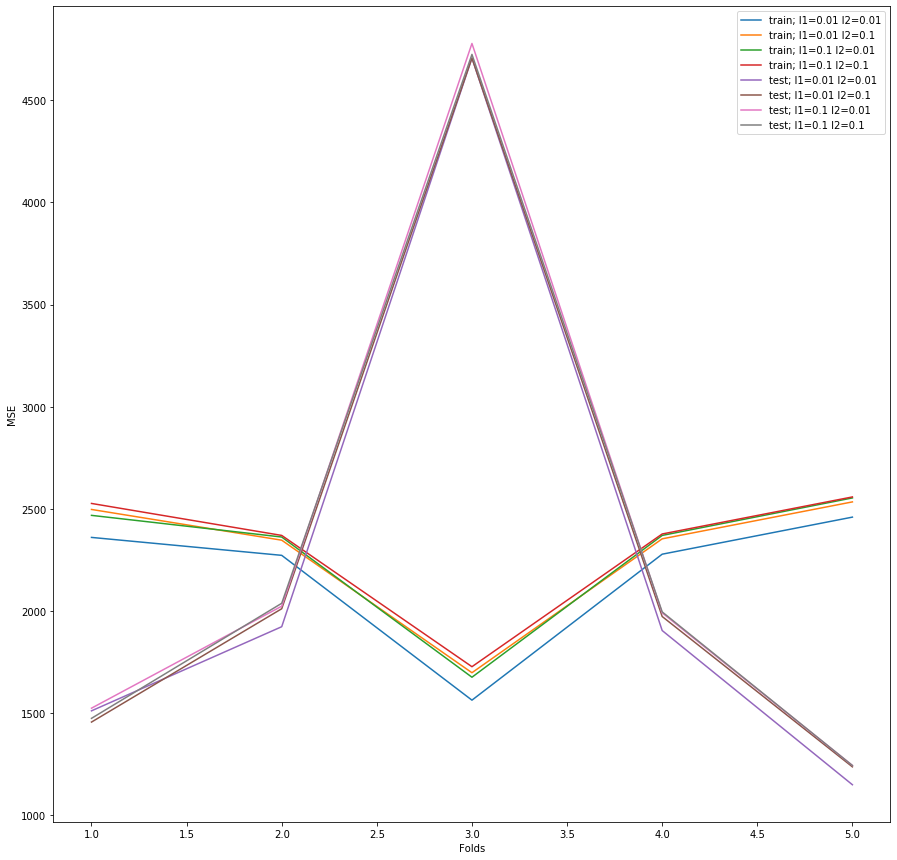

In [125]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_train'][j] for i in range(fold_count)], '-')
plt.subplot()
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['mse_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("MSE")
plt.legend(tuple(legends))   
plt.show()

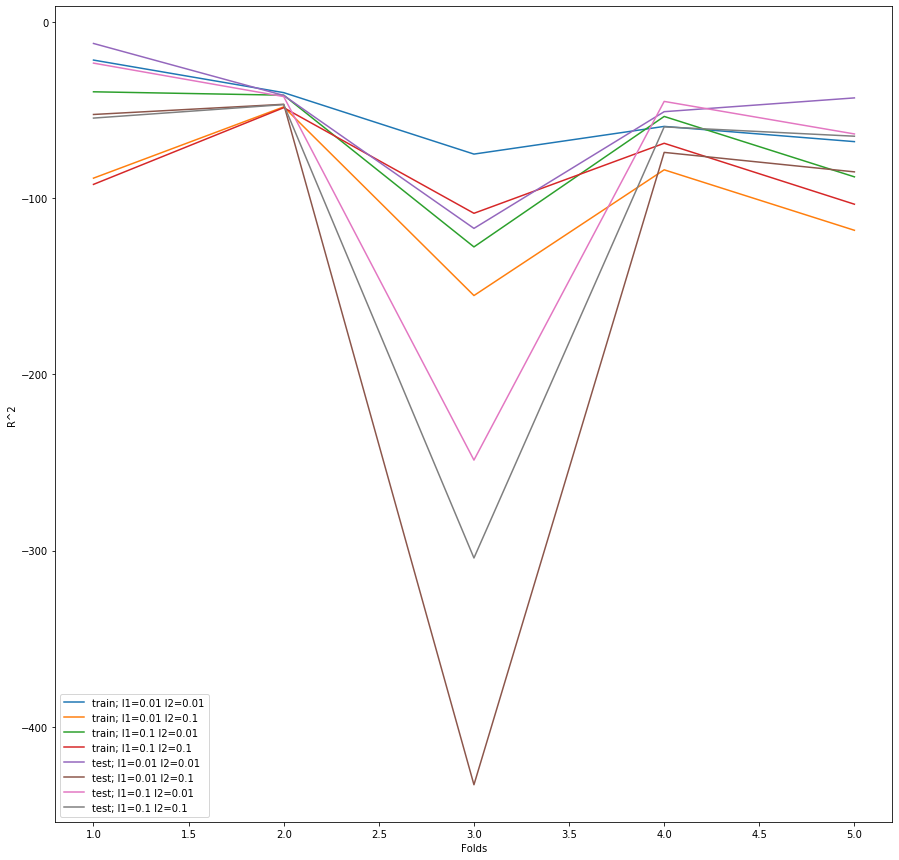

In [126]:
legends = []
plt.figure(figsize=(15, 15))
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('train; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_train'][j] for i in range(fold_count)], '-')
for j in range(len(cv_res['res'][0]['l1'])):
  legends.append('test; l1=' + str(cv_res['res'][0]['l1'][j]) + ' l2=' + str(cv_res['res'][0]['l2'][j]))
  plt.plot(range(1, fold_count+1), [cv_res['res'][i]['r2_test'][j] for i in range(fold_count)], '-')
plt.xlabel("Folds")
plt.ylabel("R^2")
plt.legend(tuple(legends))   
plt.show()